## Reading Collected LMP data 

In [54]:
import pandas as pd
import numpy as np

data=pd.read_csv("/Users/heewonahn/school_work/STA221/LMP_data_final.csv")


### storing dataframe per segment  & dividing training, test data 

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Train/Test split
train_data_condition = (data['Time'] >= '2023-10-14') & (data['Time'] <= '2024-03-17')
test_data_condition = (data['Time'] >= '2024-10-20')

# we only need segment 6 to 9 
for segment in range(6, 10):  # segment 6 to 9
    # filter 
    segment_data = data[data['closest_segment'] == segment]
    
    # Train/Test Split
    train_data = segment_data[train_data_condition]
    test_data = segment_data[test_data_condition]
    
    # file store 
    train_val_path = f"/Users/heewonahn/school_work/STA221/seg_{segment}_train_val.csv"
    test_path = f"/Users/heewonahn/school_work/STA221/seg_{segment}_test.csv"
    
    # data store 
    train_data.to_csv(train_val_path, index=False)
    test_data.to_csv(test_path, index=False)

print("Segmentation and saving completed for segments 6 to 9")



Segmentation and saving completed for segments 6 to 9


/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1109/2965744576.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = segment_data[train_data_condition]
/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1109/2965744576.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = segment_data[test_data_condition]
/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1109/2965744576.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = segment_data[train_data_condition]
/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1109/2965744576.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = segment_data[test_data_condition]
/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1109/2965744576.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data =

### reading train, test dataset

In [21]:
import pandas as pd
import numpy as np

seg_6_train = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_6_train_val.csv")
seg_6_test = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_6_test.csv")

seg_7_train = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_7_train_val.csv")
seg_7_test = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_7_test.csv")

seg_8_train = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_8_train_val.csv")
seg_8_test = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_8_test.csv")

seg_9_train = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_9_train_val.csv")
seg_9_test = pd.read_csv("/Users/heewonahn/school_work/STA221/221_LMP_project/seg_9_test.csv")

## Data preprocess & Sliding window (necessary for LSTM model)

In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler

dropcols = ['Unnamed: 0', 'Stand-alone Batteries', 'Load', 'Geothermal', 
            'Biogas', 'Small Hydro', 'Biomass', 'Nuclear', 'Natural Gas','closest_segment']

def preprocess_and_create_sliding_window(data, time_steps=24, scaler=None, is_train=True):
    """
    1. drop columns with high correlation (VIF)
    2. Sine-Cosine transformation (Hour)
    3. filling NA
    4. X, y scaling
    5. sliding window for lstm model
    
 
    Returns:
        X_lstm (np.array): LSTM input data 
        y_lstm (np.array): LSTM output data 
        scaler (StandardScaler): trained scaler
    """
    #Drop unnecessary columns
    data = data.drop(columns=[col for col in dropcols if col in data.columns])
    
    #Sin Cos transformation for Hour column
    if 'Hour' in data.columns:
        data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
        data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
        data = data.drop(columns=['Hour'])  # Drop original Hour column
    
    #Define features and target
    target = 'LMP'  # Target variable
    features = [col for col in data.columns if col not in ['LMP', 'Time']]  # Exclude LMP and Time columns
    X = data[features]
    y = data[target]
    
    #Fill missing values
    def fill_missing_values(data):
        data = data.fillna(method='ffill').fillna(method='bfill').fillna(data.mean())
        return data
    
    X = fill_missing_values(X)
    y = fill_missing_values(y)
    
    #Scaling
    if is_train:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        if scaler is None:
            raise ValueError("Provide a scaler for test data.")
        X_scaled = scaler.transform(X)
    
    #Sliding window
    X_lstm, y_lstm = [], []
    for i in range(len(X_scaled) - time_steps):
        X_lstm.append(X_scaled[i:i + time_steps])  # Sliding window for X
        y_lstm.append(y.iloc[i + time_steps])      # Align y with the last time step of the window

    # Convert to numpy arrays
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm[:len(X_lstm)])  # Align y with X
    
    return X_lstm, y_lstm, scaler


### Applying preprocessing and sliding window for train, test data

In [23]:
seg_6_X_train_lstm, seg_6_y_train_lstm, scaler = preprocess_and_create_sliding_window(
seg_6_train, time_steps=24, is_train=True)

seg_6_X_test_lstm, seg_6_y_test_lstm, _ = preprocess_and_create_sliding_window(
seg_6_test, time_steps=24, scaler=scaler,is_train=False)

seg_7_X_train_lstm, seg_7_y_train_lstm, scaler = preprocess_and_create_sliding_window(
seg_7_train, time_steps=24, is_train=True)

seg_7_X_test_lstm, seg_7_y_test_lstm, _ = preprocess_and_create_sliding_window(
seg_7_test, time_steps=24, scaler=scaler,is_train=False)

seg_8_X_train_lstm, seg_8_y_train_lstm, scaler = preprocess_and_create_sliding_window(
seg_8_train, time_steps=24, is_train=True)

seg_8_X_test_lstm, seg_8_y_test_lstm, _ = preprocess_and_create_sliding_window(
seg_8_test, time_steps=24, scaler=scaler,is_train=False)

seg_9_X_train_lstm, seg_9_y_train_lstm, scaler = preprocess_and_create_sliding_window(
seg_9_train, time_steps=24, is_train=True)

seg_9_X_test_lstm, seg_9_y_test_lstm, _ = preprocess_and_create_sliding_window(
seg_9_test, time_steps=24, scaler=scaler,is_train=False)

### Times Series Split for validation data 


In [24]:
from sklearn.model_selection import train_test_split,TimeSeriesSplit

# every segment data has equal size,so we can use common split_indices for all segments 
tscv = TimeSeriesSplit(n_splits=5)
split_indices = list(tscv.split(seg_6_X_train_lstm)) # fix indices for train and validation set 


## Model Framework 

In [25]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.3, dense_units=128, learning_rate=0.001, num_layers=1):
    """
    Parameters:
        input_shape (tuple): time_steps, n_features
        lstm_units (int): units for each lstm layers
        dropout_rate (float): dropout ratio (prevent overfitting)
        dense_units (int): Dense layer units number 
        learning_rate (float): learning rate 
        num_layers (int): number of layers
   
    """
    model = tf.keras.Sequential()

    # first LSTM layer
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=lstm_units,
            activation='tanh',
            return_sequences=(num_layers > 1),  # if more than 1 layer, return_sequences=True
            input_shape=input_shape
        )
    ))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # add extra LSTM layer (if num_layers > 1)
    for i in range(1, num_layers):
        model.add(tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units=lstm_units,
                activation='tanh',
                return_sequences=(i < num_layers - 1)  #  return_sequences=True except last layer
            )
        ))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Dense layer
    model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # output layer
    model.add(tf.keras.layers.Dense(1, activation='linear'))  

    # model configuration
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model


# segment 6 model

## segment 6 model parameter tuning

Testing parameters: (64, 0.3, 64, 0.001, 2)
20/20 [==============================] - 1s 4ms/step
Average MSE for parameters (64, 0.3, 64, 0.001, 2): 1390.0601044079738
Average Validation Loss for parameters (64, 0.3, 64, 0.001, 2): 2340.660332884177
Testing parameters: (128, 0.3, 64, 0.001, 2)
20/20 [==============================] - 1s 8ms/step
Average MSE for parameters (128, 0.3, 64, 0.001, 2): 1941.9688725492626
Average Validation Loss for parameters (128, 0.3, 64, 0.001, 2): 2694.0983130252725
Testing parameters: (32, 0.3, 64, 0.001, 1)
20/20 [==============================] - 0s 1ms/step
Average MSE for parameters (32, 0.3, 64, 0.001, 1): 1333.2598696546552
Average Validation Loss for parameters (32, 0.3, 64, 0.001, 1): 2218.531210462782
Testing parameters: (128, 0.2, 256, 0.001, 1)
20/20 [==============================] - 0s 4ms/step
Average MSE for parameters (128, 0.2, 256, 0.001, 1): 639.8221141892408
Average Validation Loss for parameters (128, 0.2, 256, 0.001, 1): 1774.7778

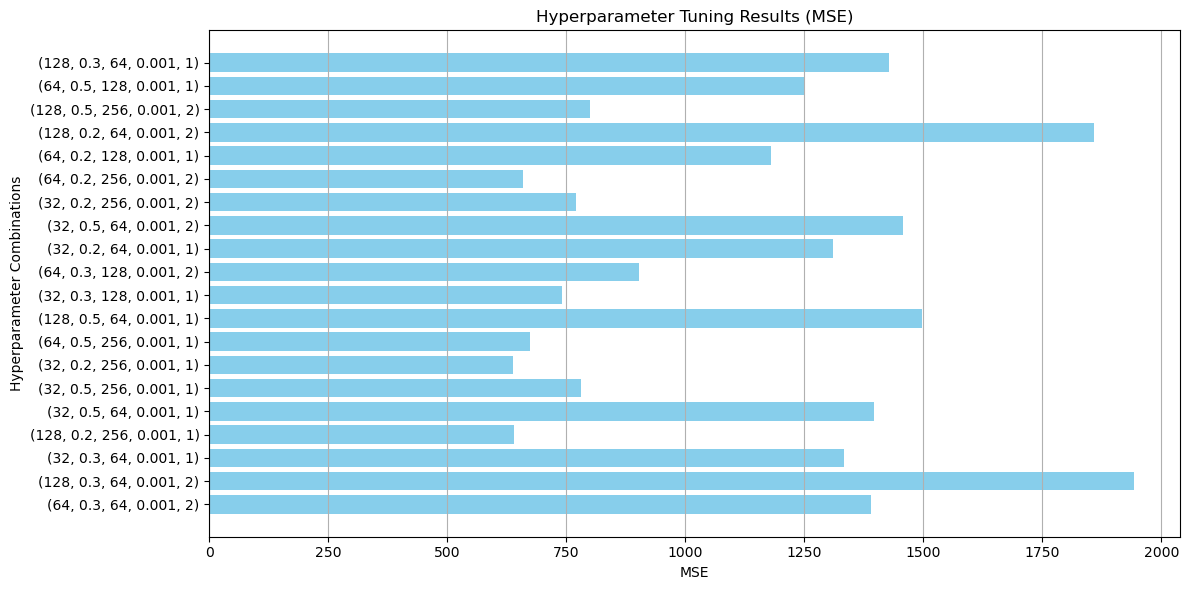

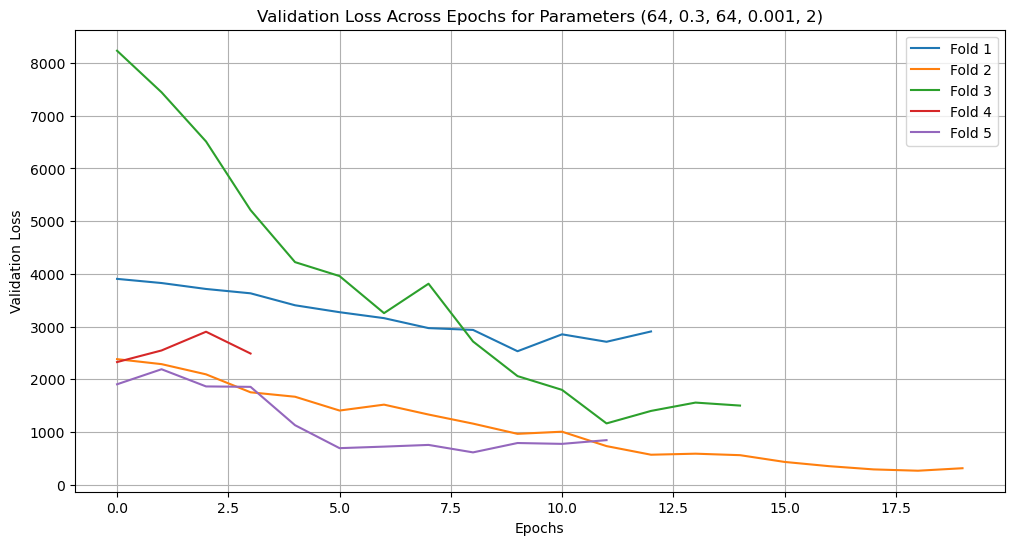

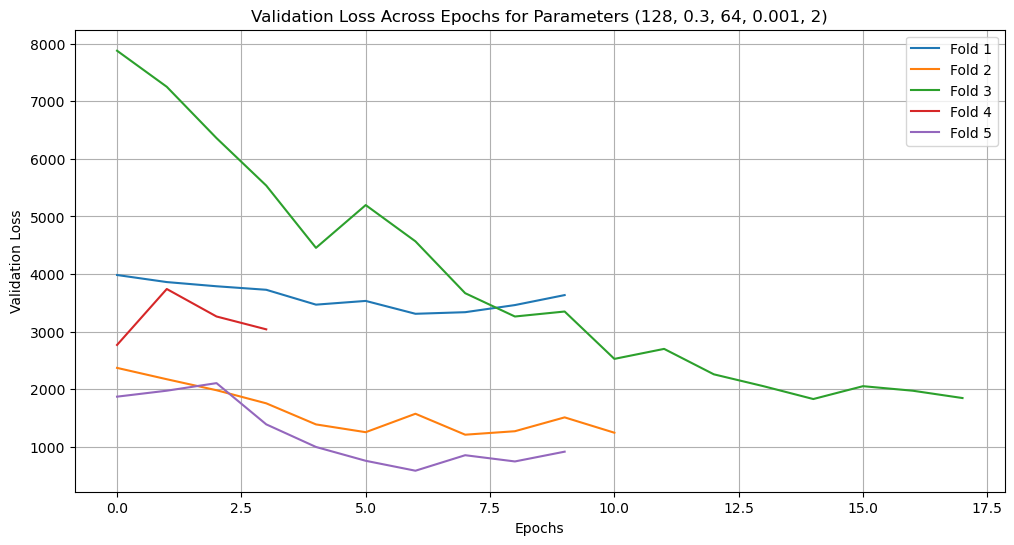

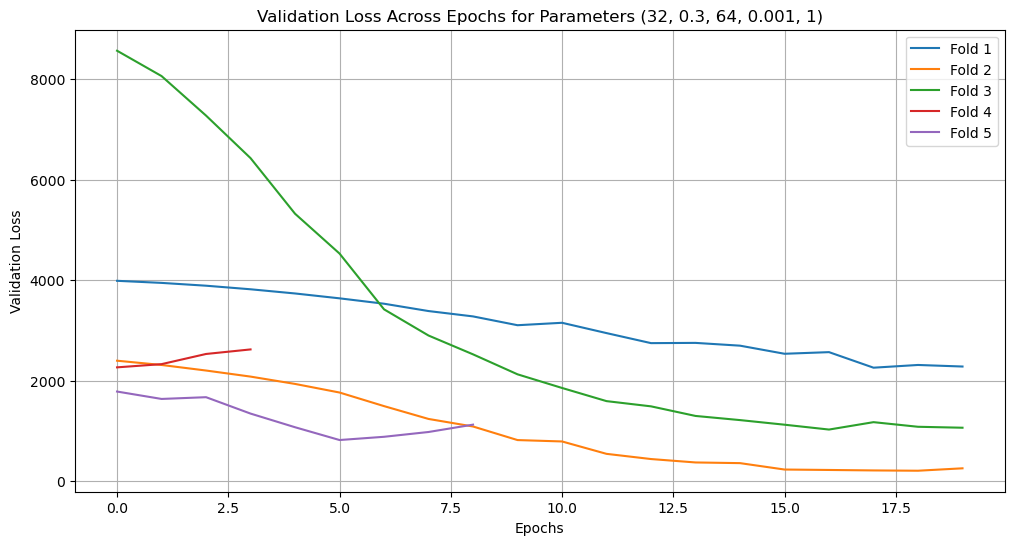

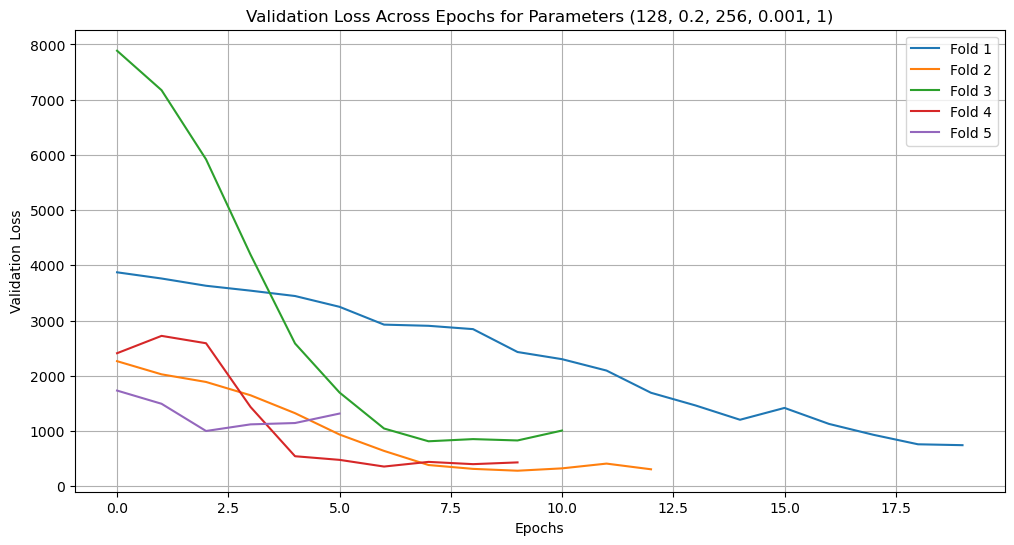

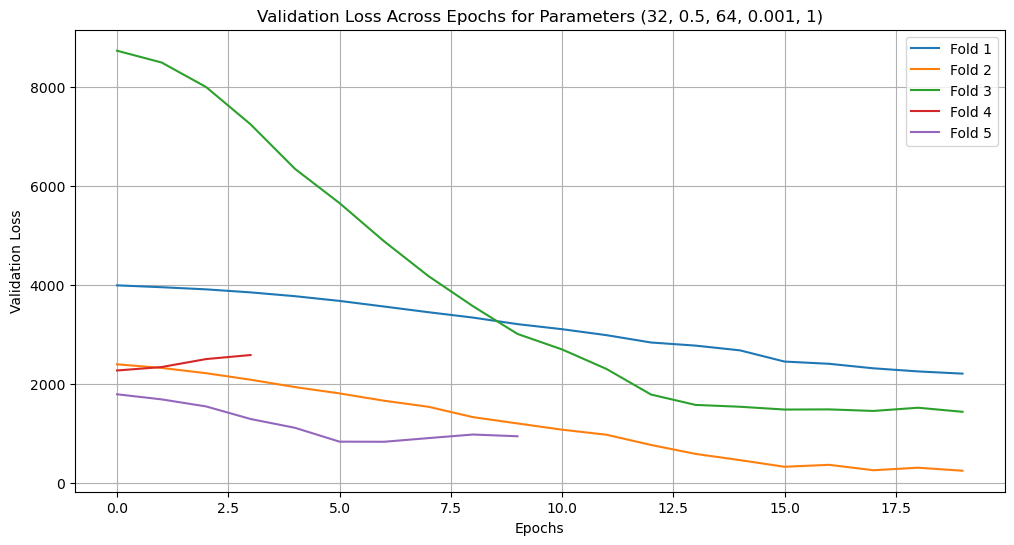

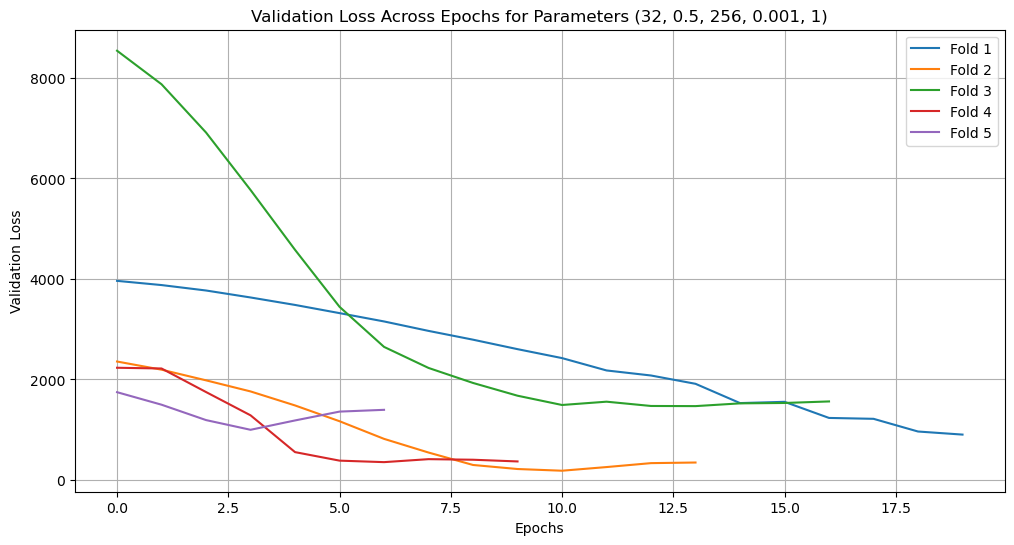

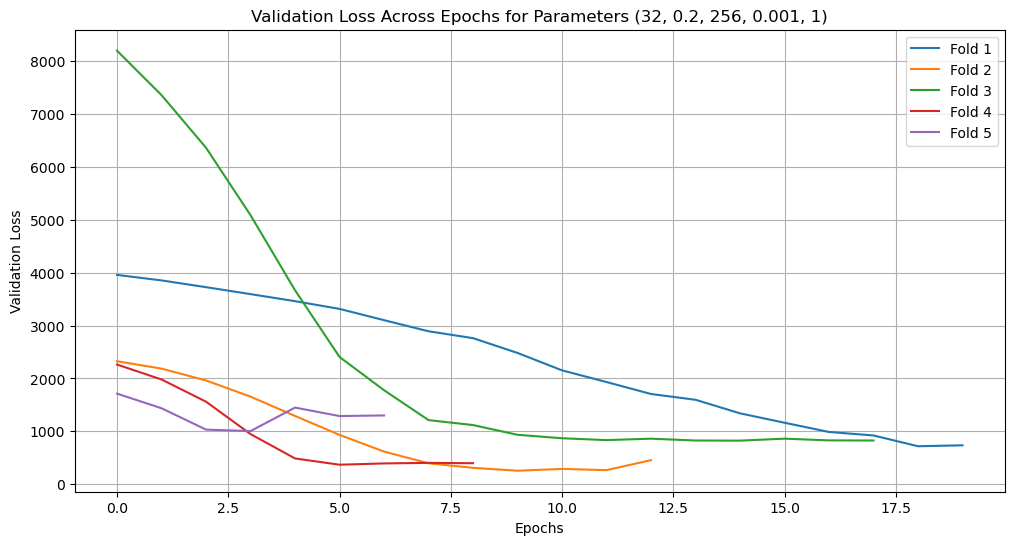

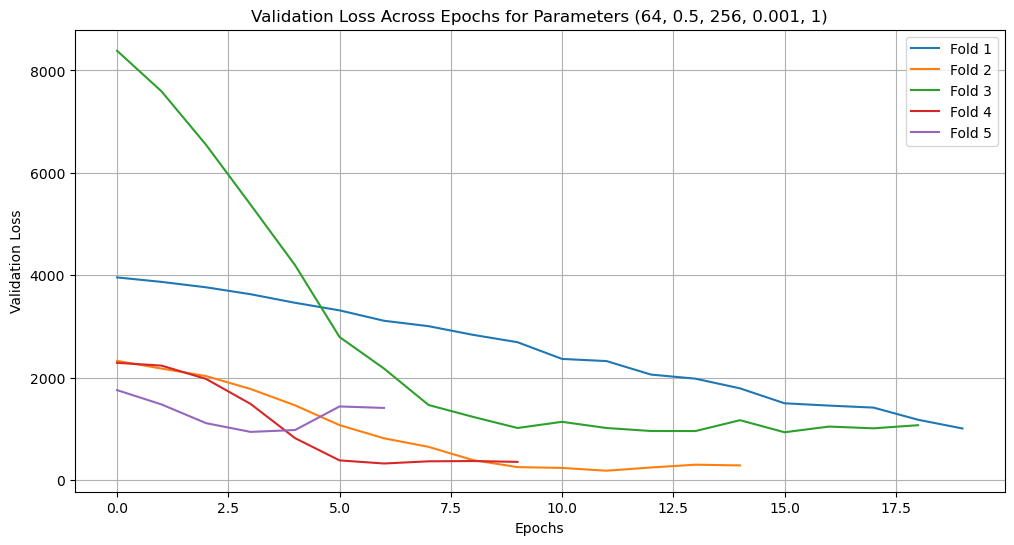

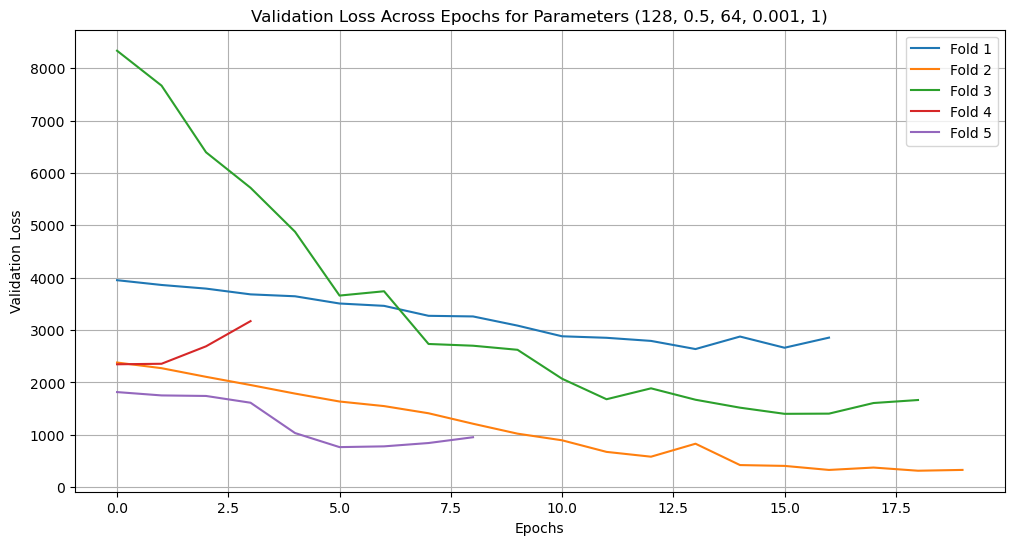

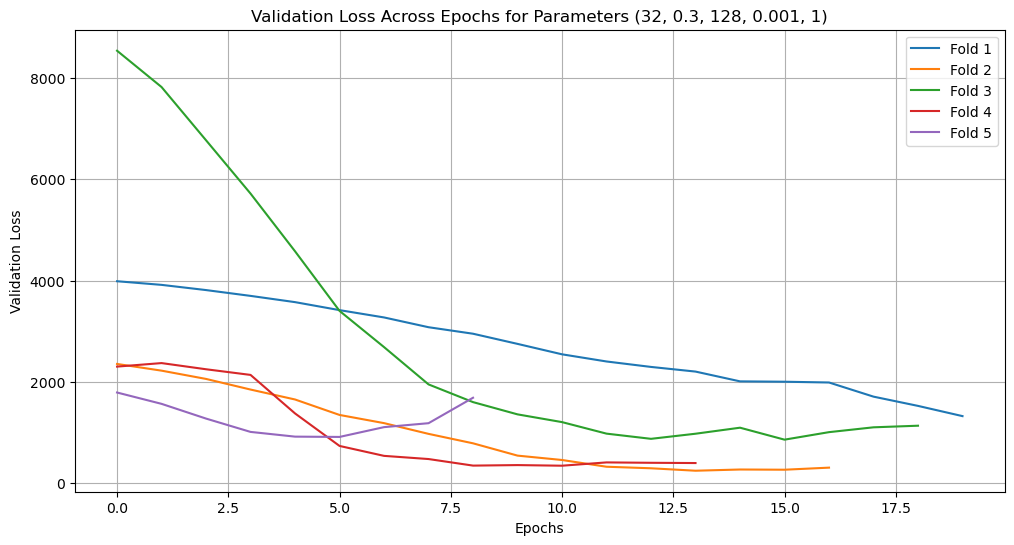

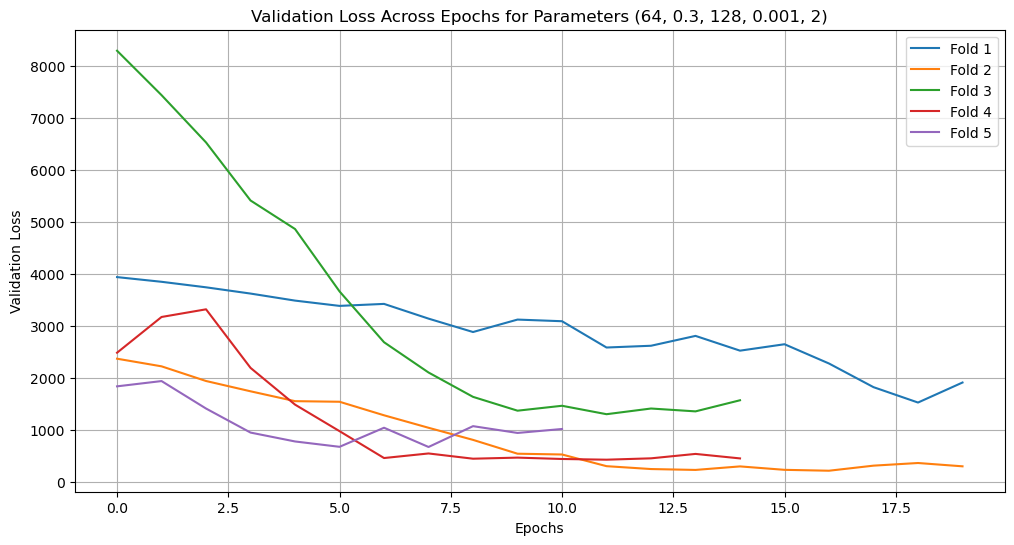

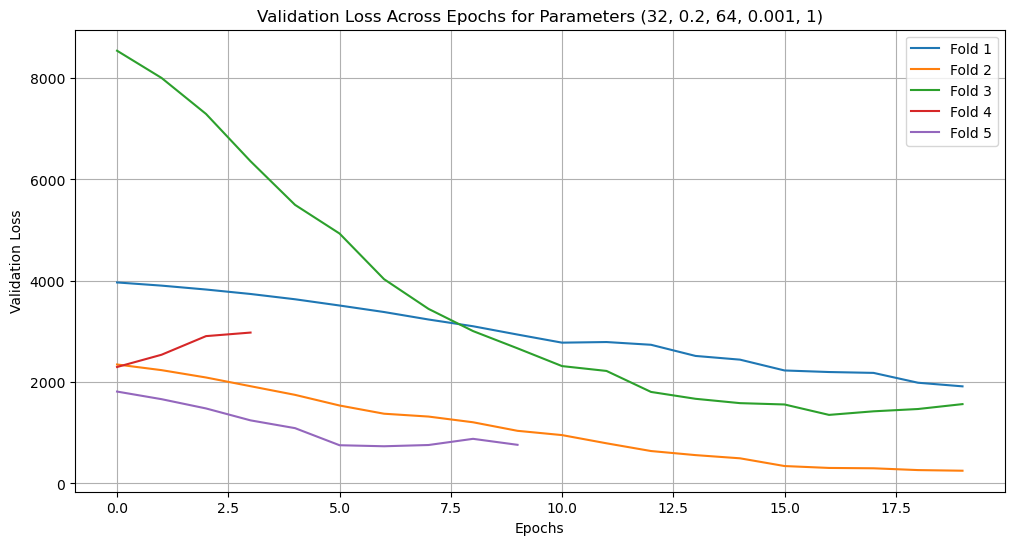

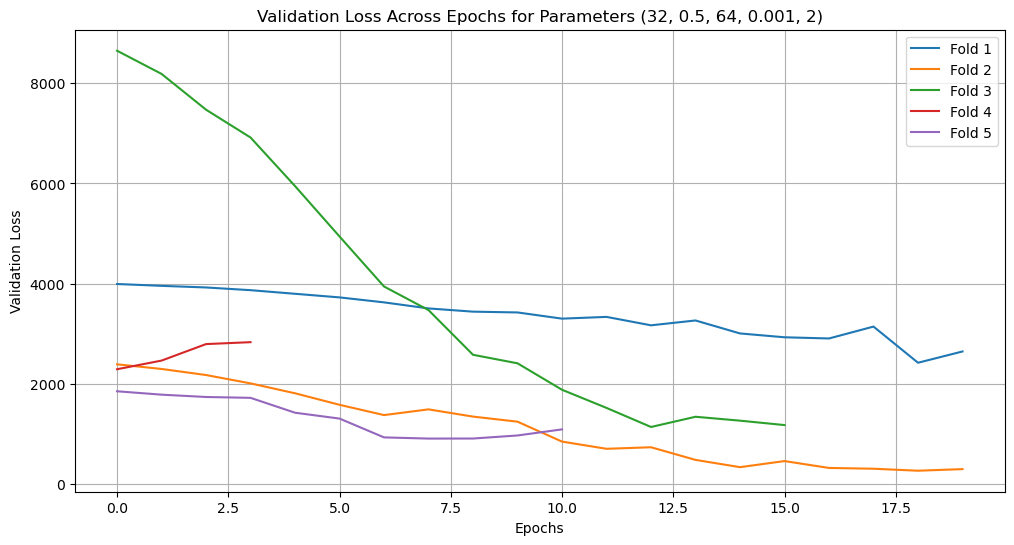

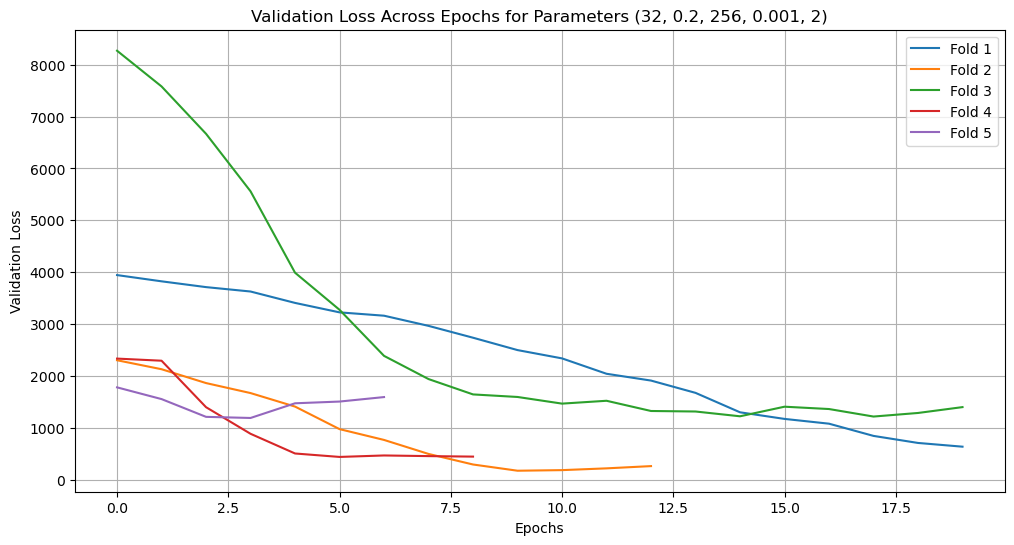

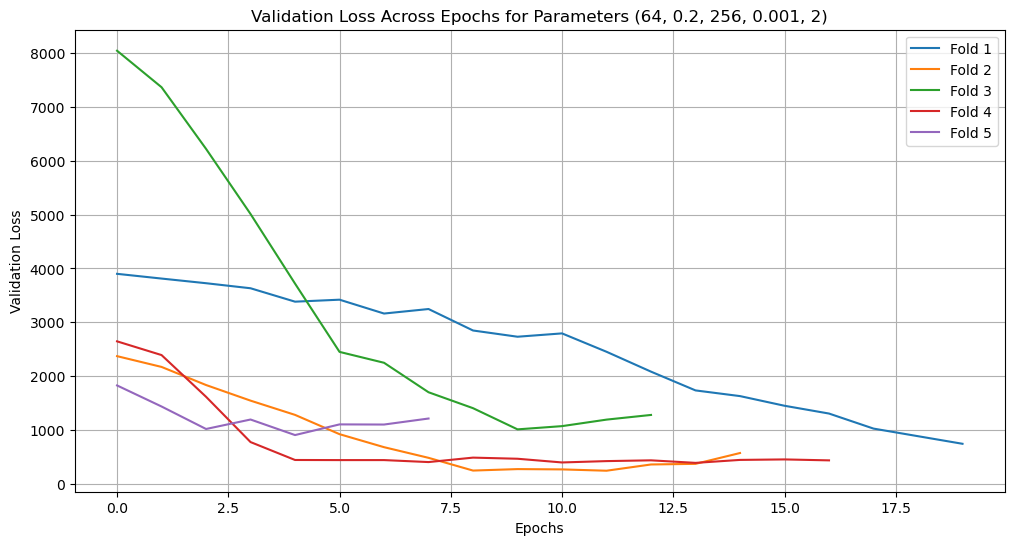

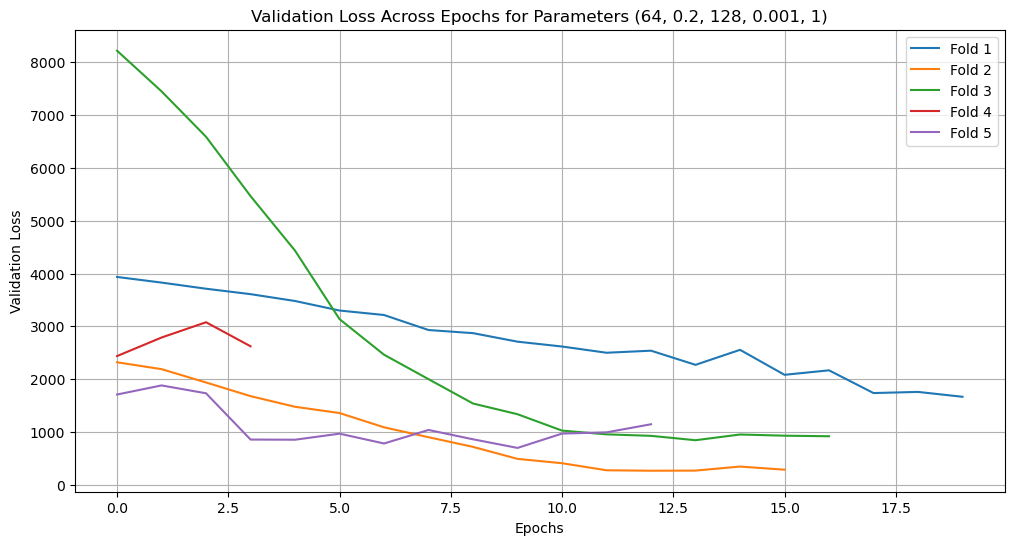

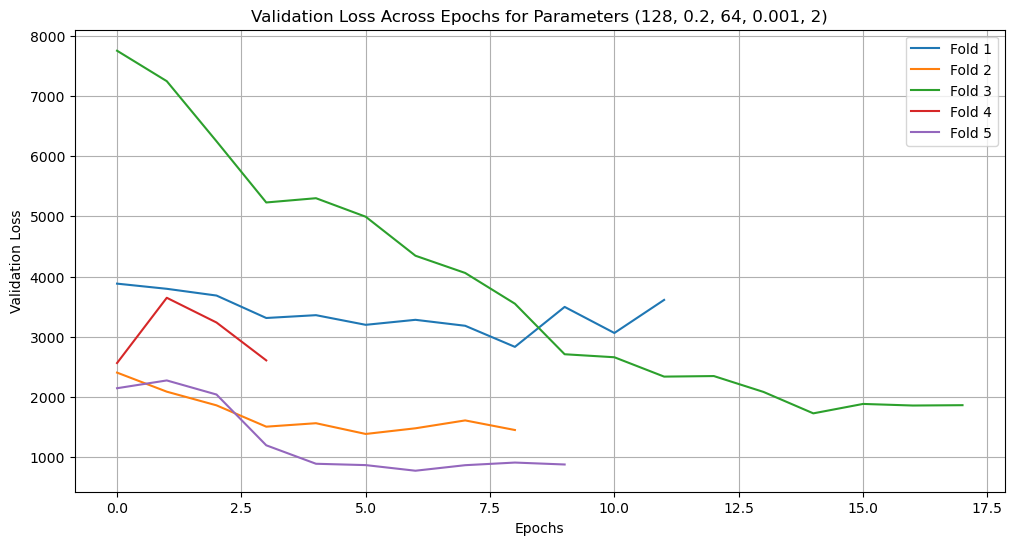

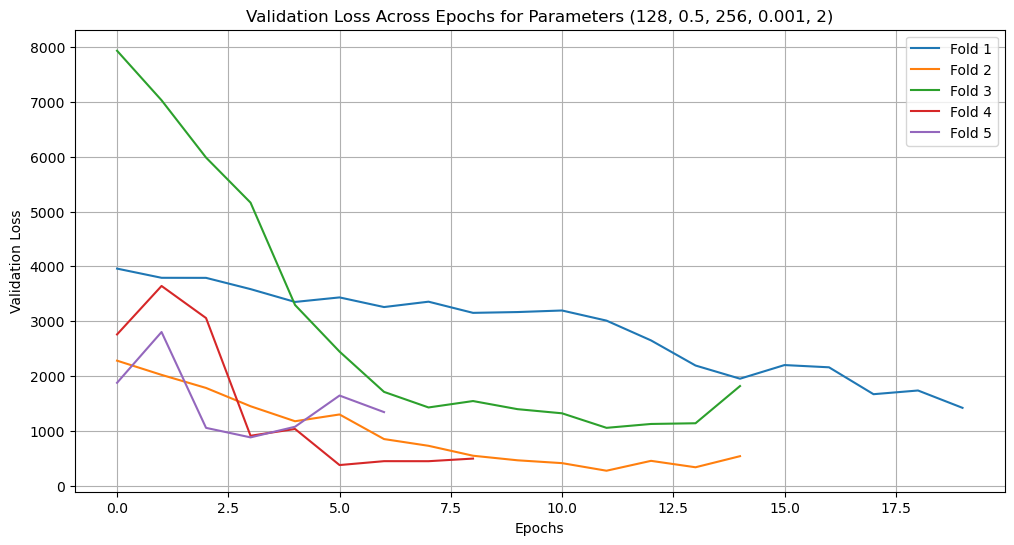

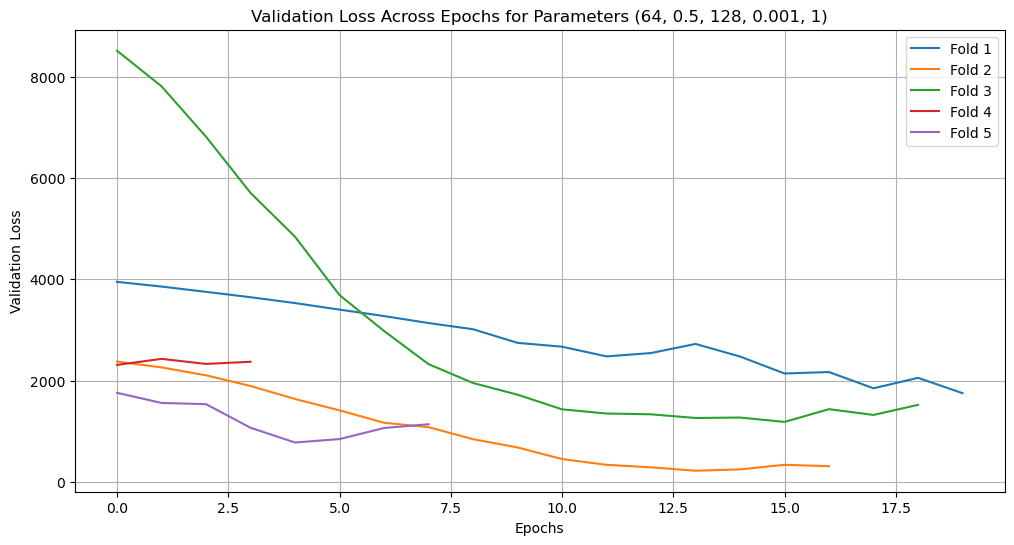

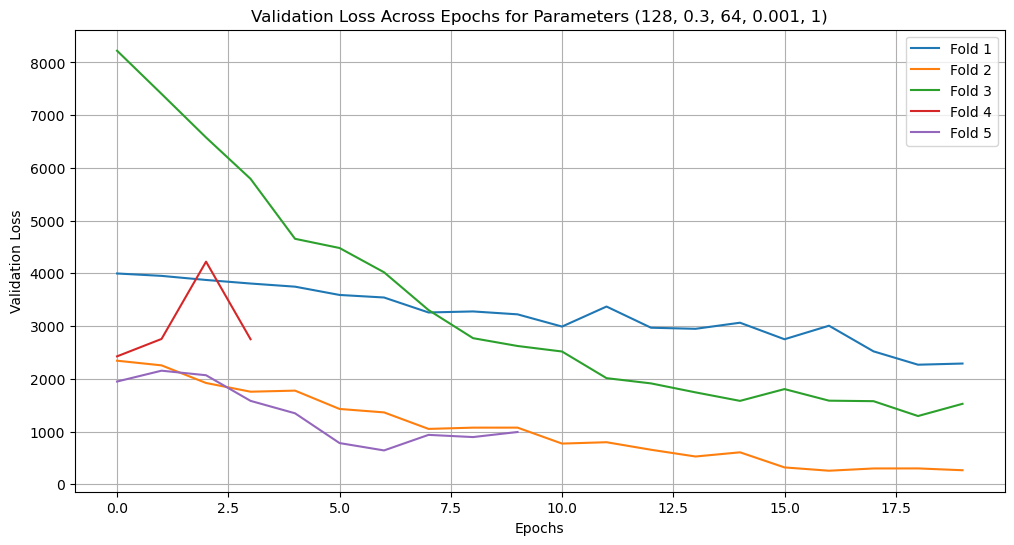

In [35]:
from itertools import product  # itertools 모듈에서 product 임포트
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import sample




param_grid = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'dense_units': [64, 128, 256],
    'learning_rate': [0.001],
    'num_layers': [1, 2]
}

# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['learning_rate'],
    param_grid['num_layers']
))




# Store results
results = []
validation_loss_tracking = {}


num_samples = 20  
random_combinations = sample(param_combinations, num_samples)

# random_combinations of 20 samples (grid search took too much time)
for params in random_combinations:
    lstm_units, dropout_rate, dense_units, learning_rate, num_layers = params
    print(f"Testing parameters: {params}")
    scores = []
    validation_losses = []

    for train_idx, val_idx in split_indices: #fixed index
        X_train, X_val = seg_6_X_train_lstm[train_idx], seg_6_X_train_lstm[val_idx]
        y_train, y_val = seg_6_y_train_lstm[train_idx], seg_6_y_train_lstm[val_idx]

        # Build model
        model = build_lstm_model(
            input_shape= (X_train.shape[1], X_train.shape[2]),
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            dense_units=dense_units,
            learning_rate=learning_rate,
            num_layers=num_layers
        )
        # Early stopping
        early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Store validation loss per epoch
        validation_losses.append(history.history['val_loss'])

        # Validation predictions
        y_val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        scores.append(mse)

    # Average MSE and validation loss
    avg_score = np.mean(scores)
    avg_val_loss = np.mean([np.mean(losses) for losses in validation_losses])
    results.append({'params': params, 'mse': avg_score})
    validation_loss_tracking[str(params)] = validation_losses

    print(f"Average MSE for parameters {params}: {avg_score}")
    print(f"Average Validation Loss for parameters {params}: {avg_val_loss}")

# Find the best parameters with MSE
best_result = min(results, key=lambda x: x['mse'])
print("\nBest Parameters:")
print(best_result['params'])
print(f"Best Score (MSE): {best_result['mse']}")

# Visualization of results 
mse_values = [result['mse'] for result in results]
labels = [str(result['params']) for result in results]

plt.figure(figsize=(12, 6))
plt.barh(labels, mse_values, color='skyblue')
plt.xlabel('MSE')
plt.ylabel('Hyperparameter Combinations')
plt.title('Hyperparameter Tuning Results (MSE)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Validation Loss Visualization
for params, val_losses in validation_loss_tracking.items():
    plt.figure(figsize=(12, 6))
    for fold, losses in enumerate(val_losses):
        plt.plot(losses, label=f'Fold {fold + 1}')
    plt.title(f'Validation Loss Across Epochs for Parameters {params}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


## Final model for segment 6

Epoch 1/20
115/115 [==============================] - 2s 4ms/step - loss: 3107.0388 - mae: 49.1914
Epoch 2/20
115/115 [==============================] - 0s 3ms/step - loss: 2034.7455 - mae: 40.0495
Epoch 3/20
115/115 [==============================] - 0s 4ms/step - loss: 1088.9529 - mae: 27.9458
Epoch 4/20
115/115 [==============================] - 0s 3ms/step - loss: 510.0734 - mae: 16.8844
Epoch 5/20
115/115 [==============================] - 0s 3ms/step - loss: 374.1881 - mae: 13.2330
Epoch 6/20
115/115 [==============================] - 0s 3ms/step - loss: 332.6393 - mae: 12.4341
Epoch 7/20
115/115 [==============================] - 0s 3ms/step - loss: 315.5886 - mae: 12.0975
Epoch 8/20
115/115 [==============================] - 0s 3ms/step - loss: 296.0821 - mae: 11.8606
Epoch 9/20
115/115 [==============================] - 0s 3ms/step - loss: 290.1013 - mae: 11.6335
Epoch 10/20
115/115 [==============================] - 0s 3ms/step - loss: 274.4973 - mae: 11.4837
Epoch 11/20
115/

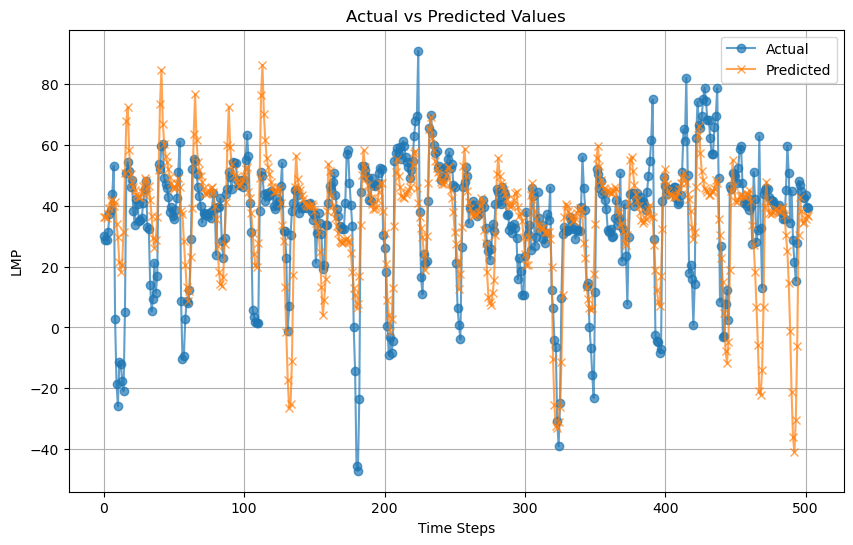

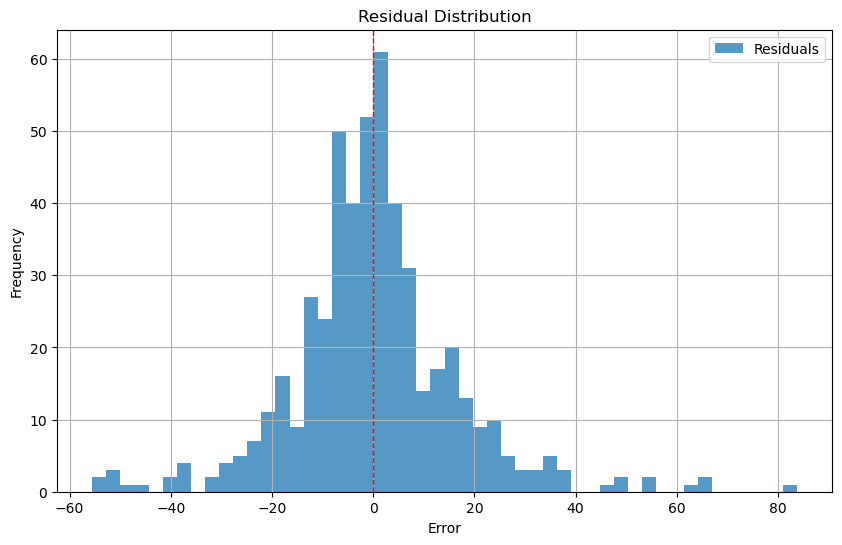

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


best_params_seg_6 = {
    'lstm_units': 32,
    'dropout_rate': 0.2,
    'dense_units': 256,
    'learning_rate': 0.001,
    'num_layers': 1
}

# Input shape for segment 6
input_shape = (seg_6_X_train_lstm.shape[1], seg_6_X_train_lstm.shape[2])

# Build model using best parameters
model_6 = build_lstm_model(
    input_shape=input_shape,
    lstm_units=best_params_seg_6['lstm_units'],
    dropout_rate=best_params_seg_6['dropout_rate'],
    dense_units=best_params_seg_6['dense_units'],
    learning_rate=best_params_seg_6['learning_rate'],
    num_layers=best_params_seg_6['num_layers']
)


# Train the model on the full training data
history_6 = model_6.fit(
    seg_6_X_train_lstm, seg_6_y_train_lstm,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
seg_6_y_pred = model_6.predict(seg_6_X_test_lstm)

# Calculate MAE and MSE
mae_6 = mean_absolute_error(seg_6_y_test_lstm, seg_6_y_pred)
mse_6 = mean_squared_error(seg_6_y_test_lstm, seg_6_y_pred)

print(f"Mean Absolute Error (MAE): {mae_6}")
print(f"Mean Squared Error (MSE): {mse_6}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(seg_6_y_test_lstm, label='Actual', marker='o', alpha=0.7)
plt.plot(seg_6_y_pred, label='Predicted', marker='x', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('LMP')
plt.grid()
plt.show()

# Residual Analysis
seg_6_residuals = seg_6_y_test_lstm - seg_6_y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(seg_6_residuals, bins=50, alpha=0.75, label='Residuals')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residual Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


# segment 7 model

## segment 7 model parameter tuning

Testing parameters: (32, 0.3, 256, 0.001, 2)
20/20 [==============================] - 1s 2ms/step
Average MSE for parameters (32, 0.3, 256, 0.001, 2): 445.9229553997003
Average Validation Loss for parameters (32, 0.3, 256, 0.001, 2): 1455.0330969674246
Testing parameters: (128, 0.2, 64, 0.001, 2)
20/20 [==============================] - 1s 9ms/step
Average MSE for parameters (128, 0.2, 64, 0.001, 2): 1679.4606523269763
Average Validation Loss for parameters (128, 0.2, 64, 0.001, 2): 2339.7630984995726
Testing parameters: (64, 0.2, 256, 0.001, 1)
20/20 [==============================] - 0s 1ms/step
Average MSE for parameters (64, 0.2, 256, 0.001, 1): 416.36739365285996
Average Validation Loss for parameters (64, 0.2, 256, 0.001, 1): 1320.4926310947963
Testing parameters: (128, 0.5, 64, 0.001, 2)
20/20 [==============================] - 1s 10ms/step
Average MSE for parameters (128, 0.5, 64, 0.001, 2): 1134.2535696293858
Average Validation Loss for parameters (128, 0.5, 64, 0.001, 2): 207

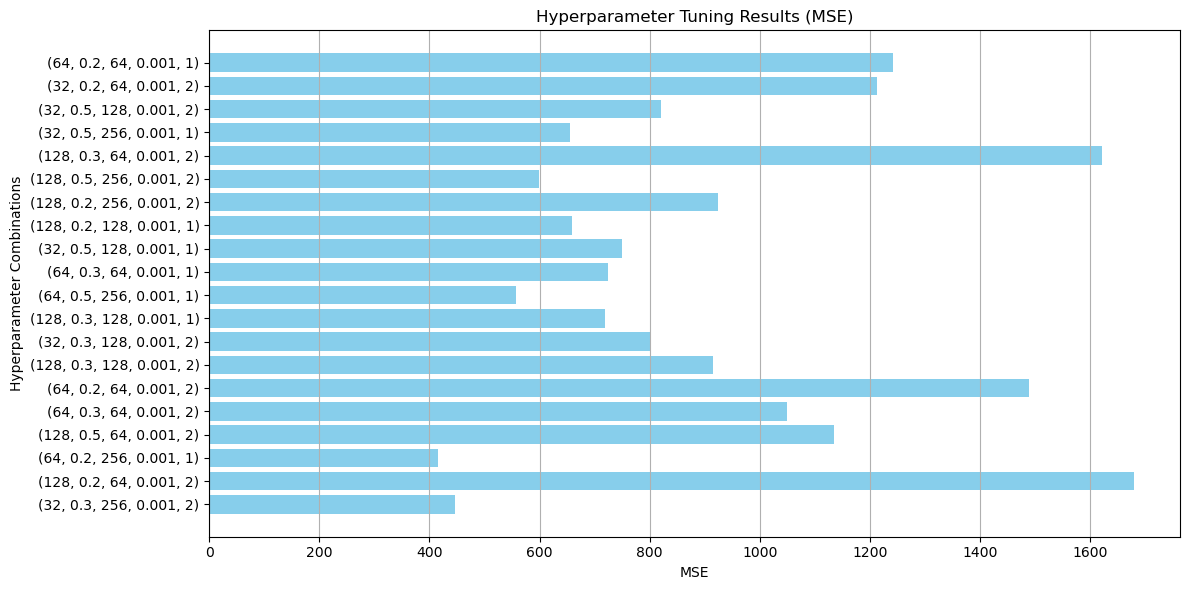

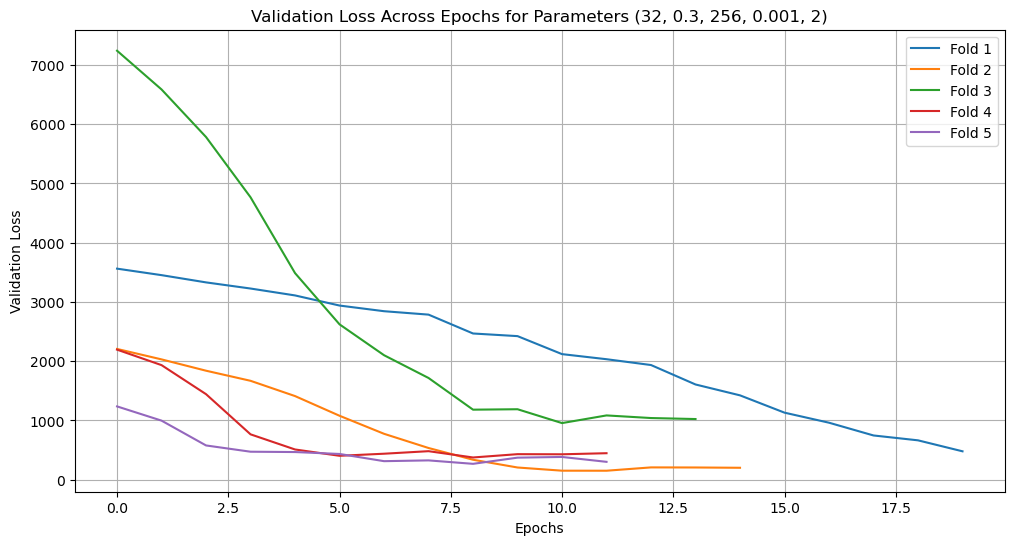

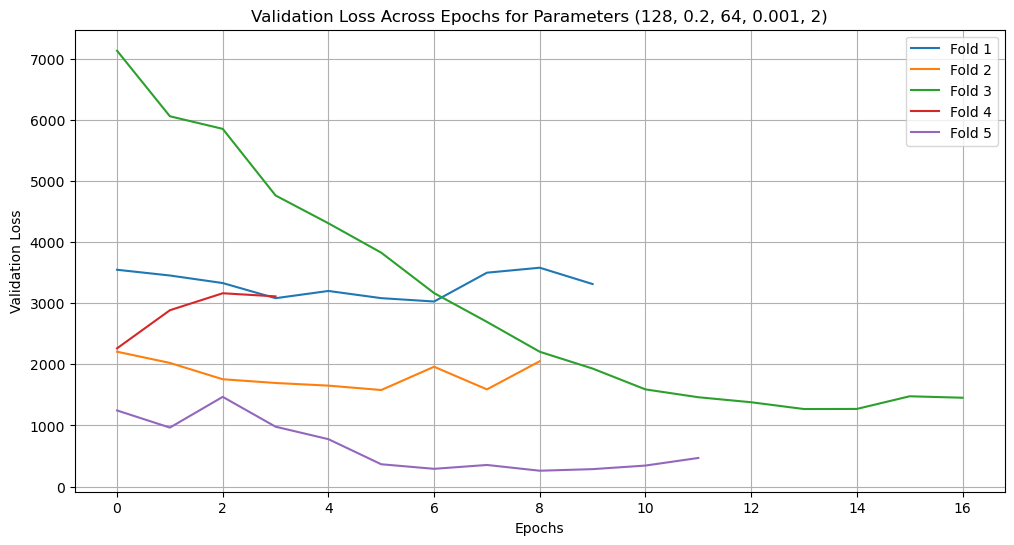

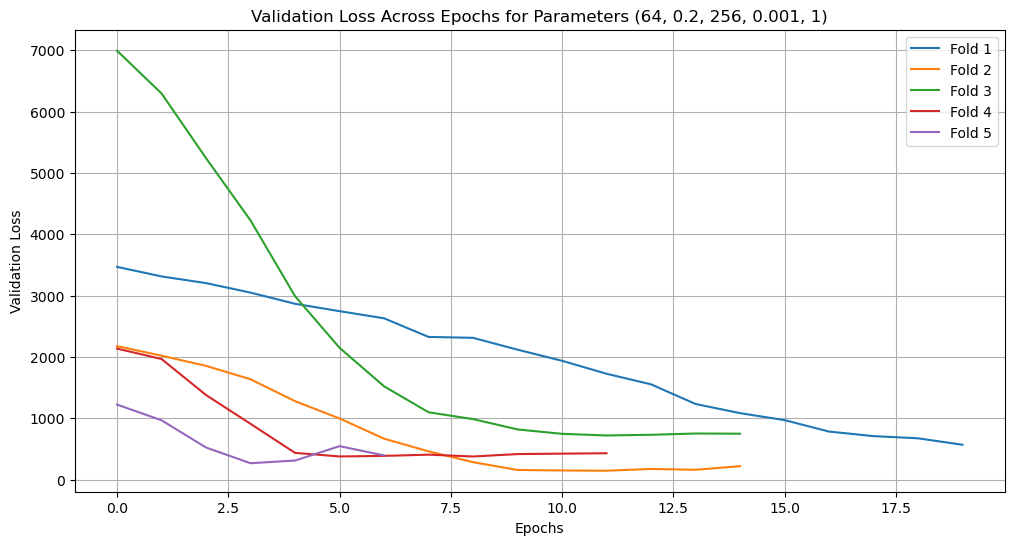

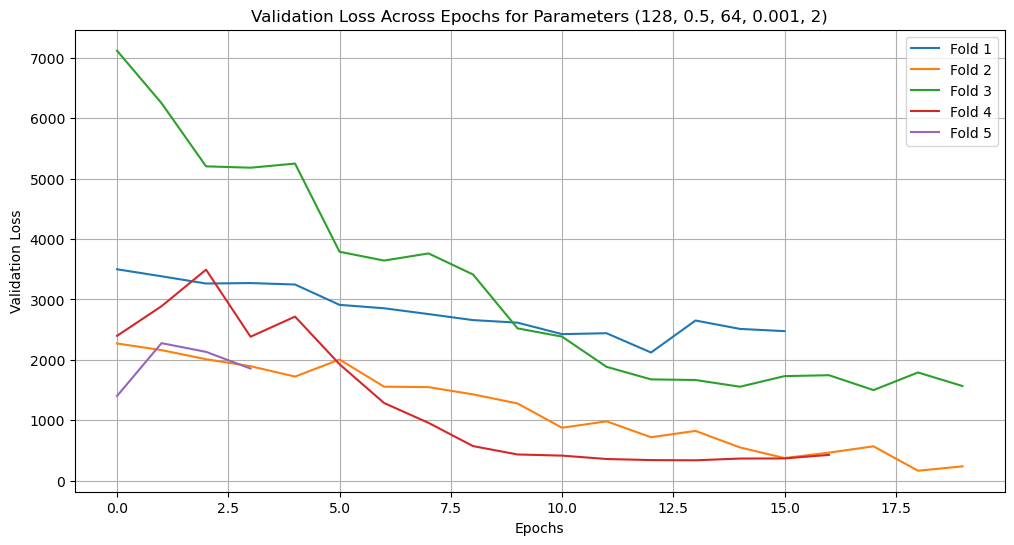

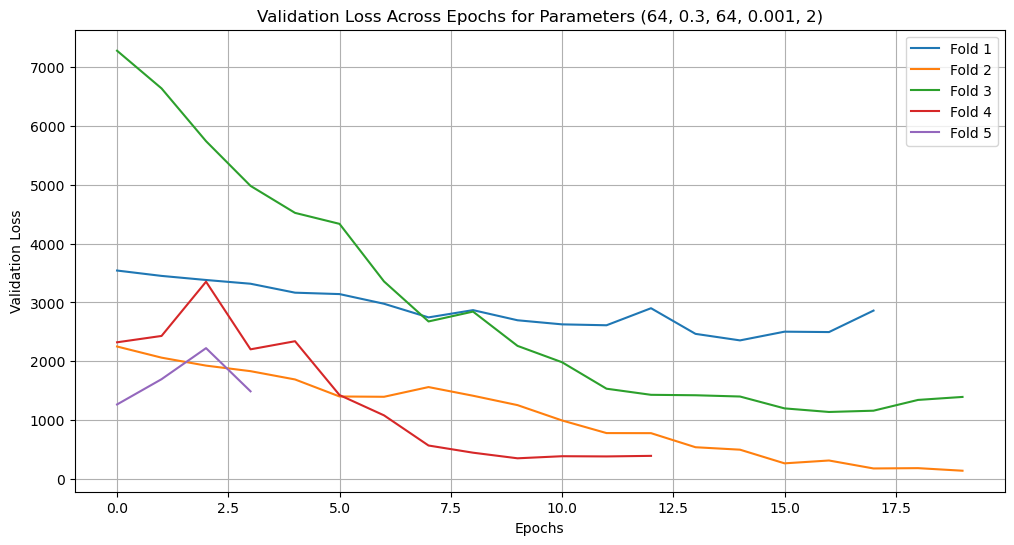

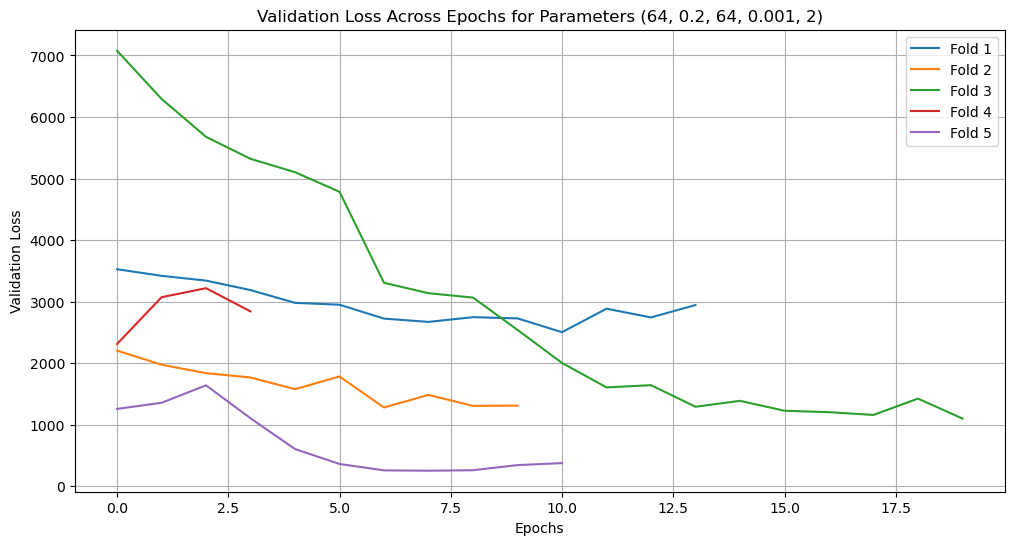

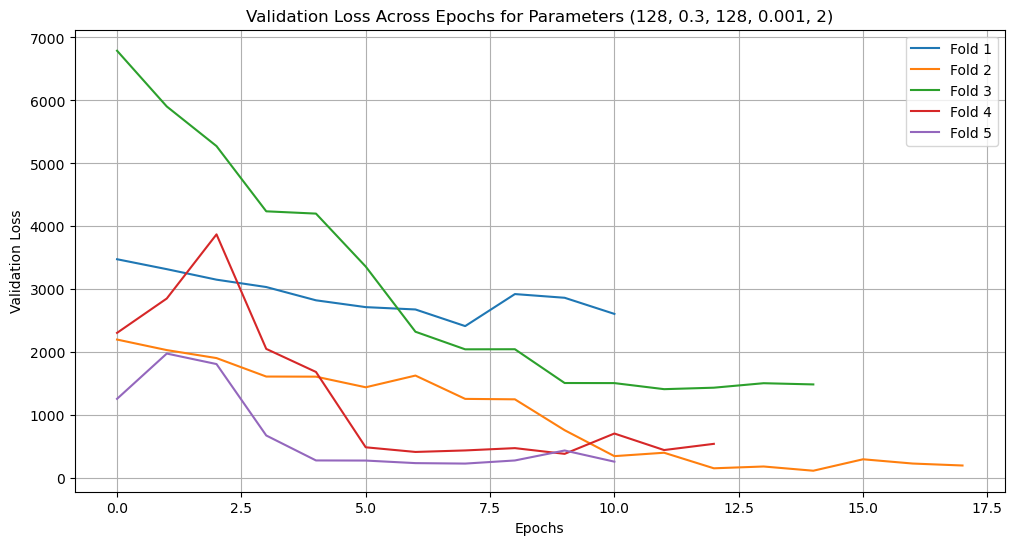

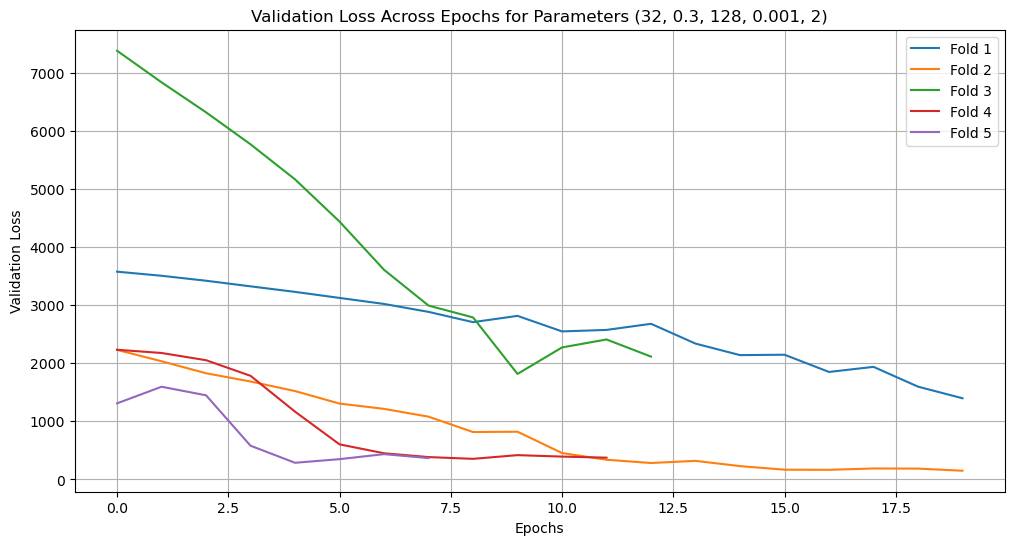

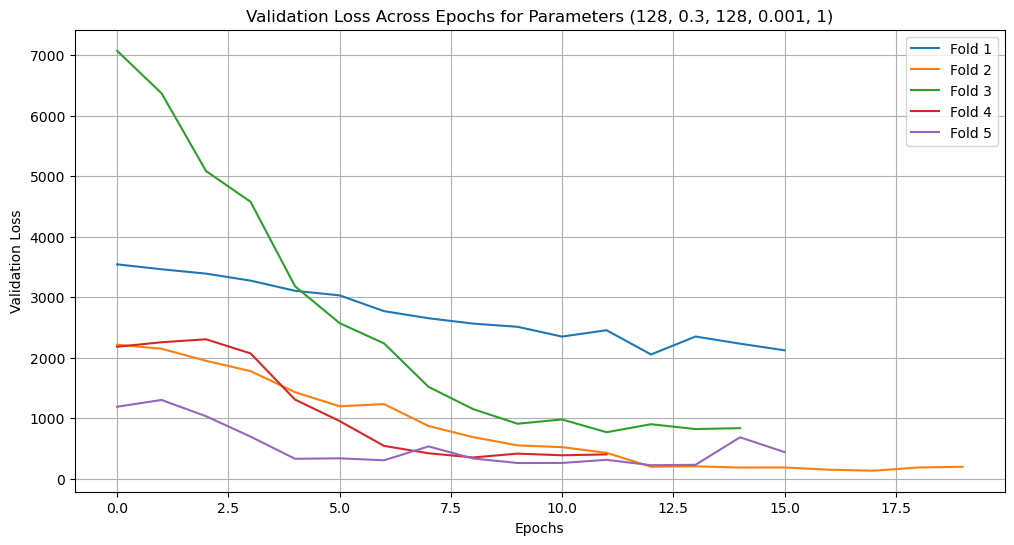

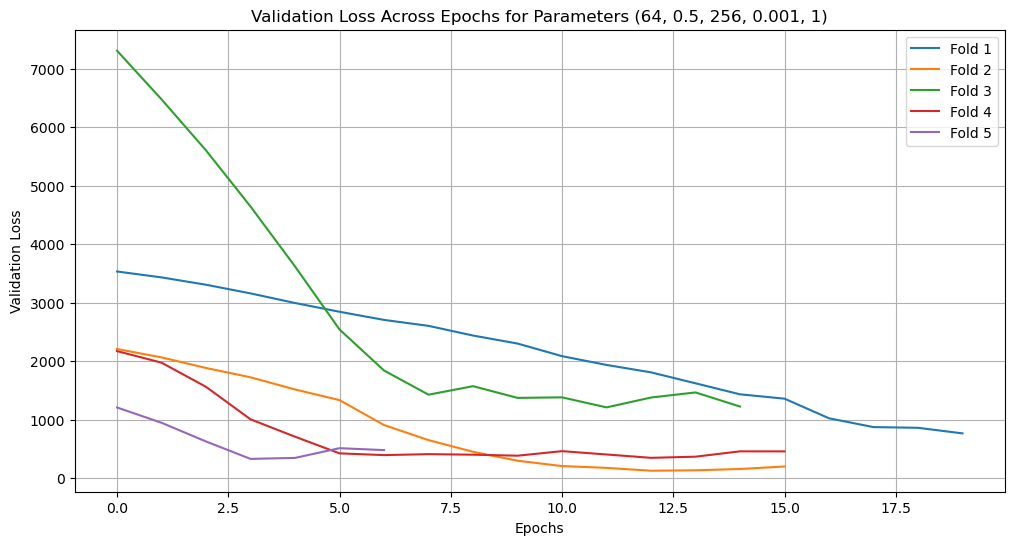

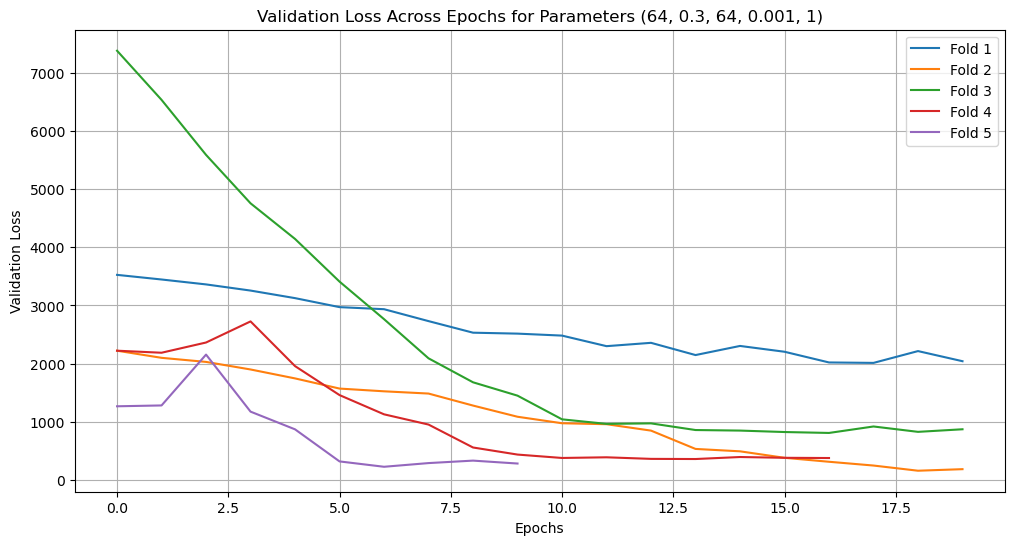

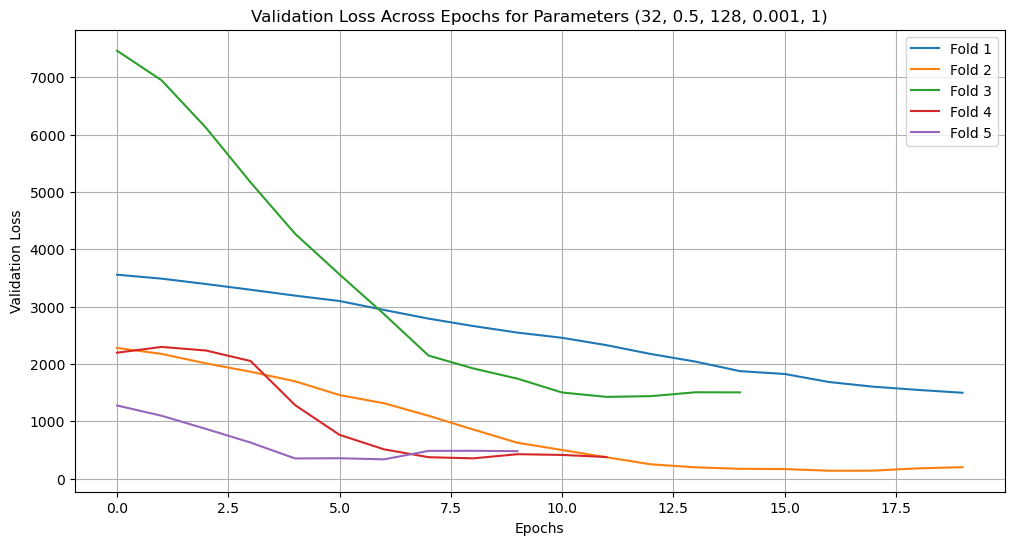

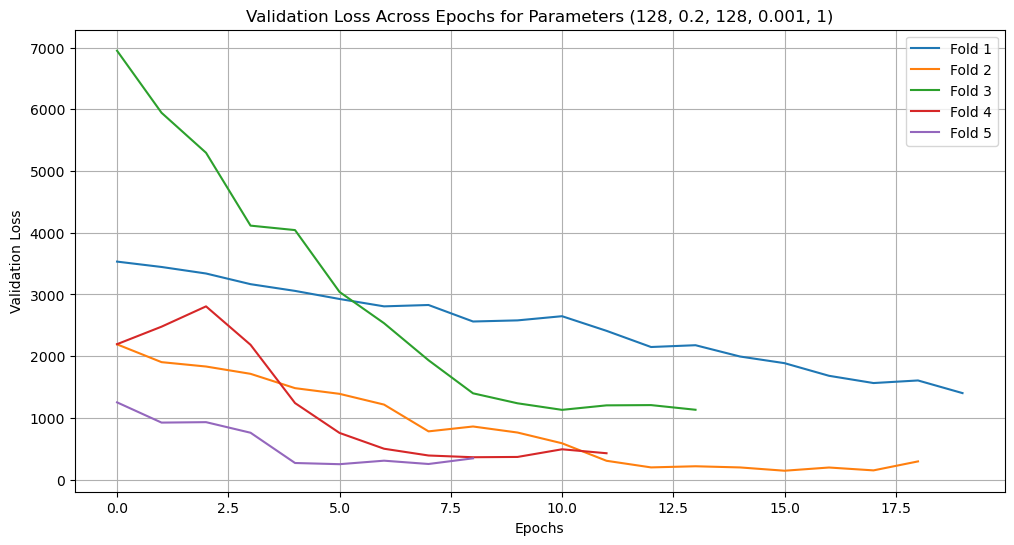

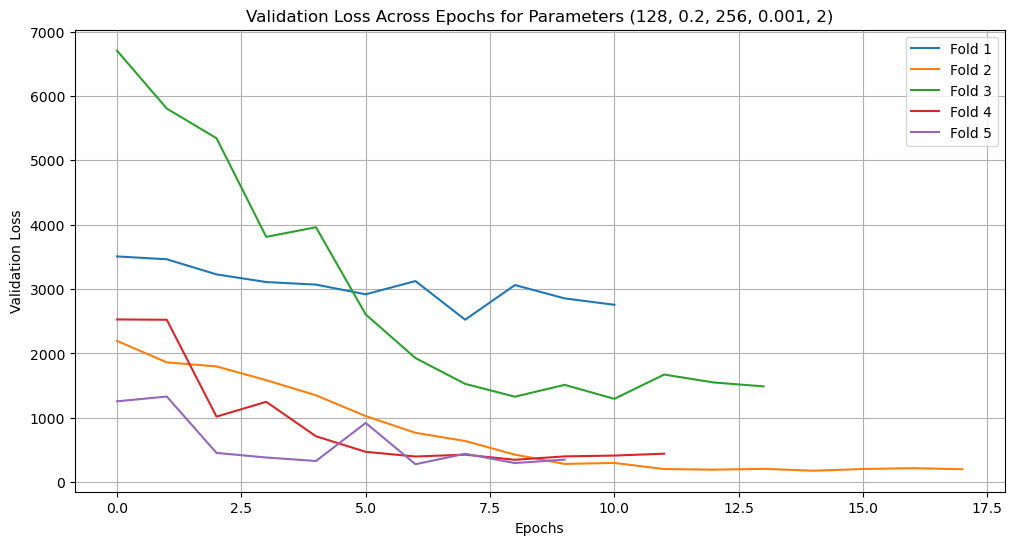

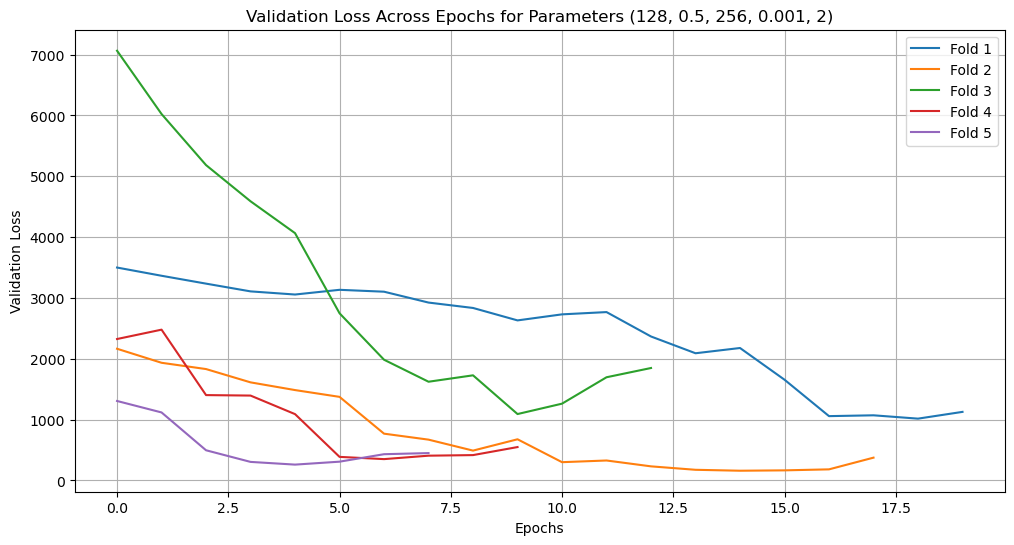

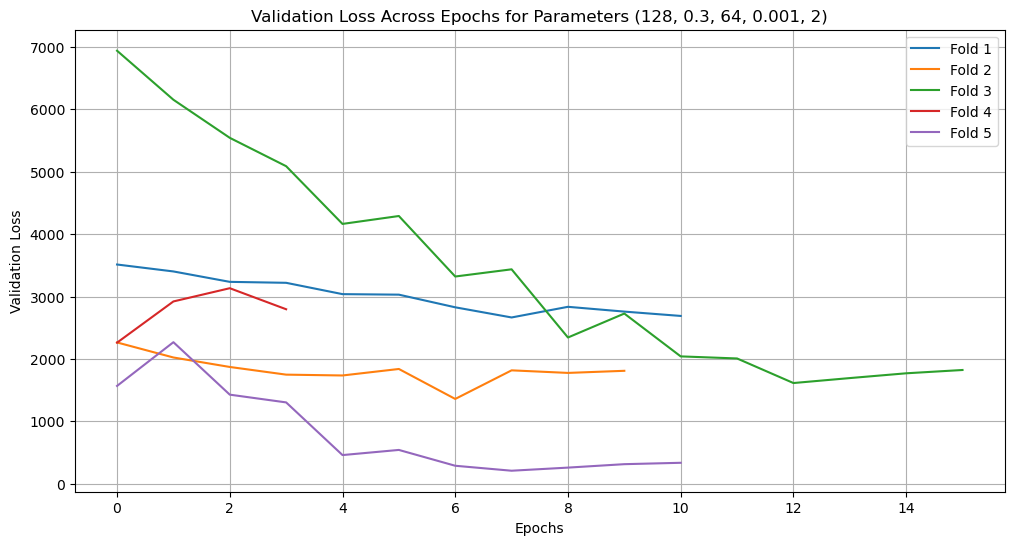

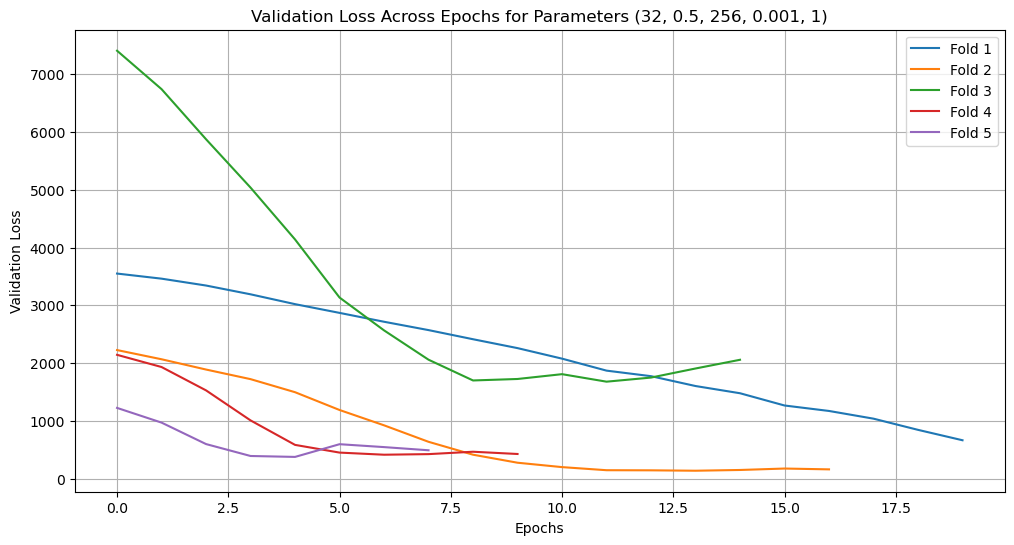

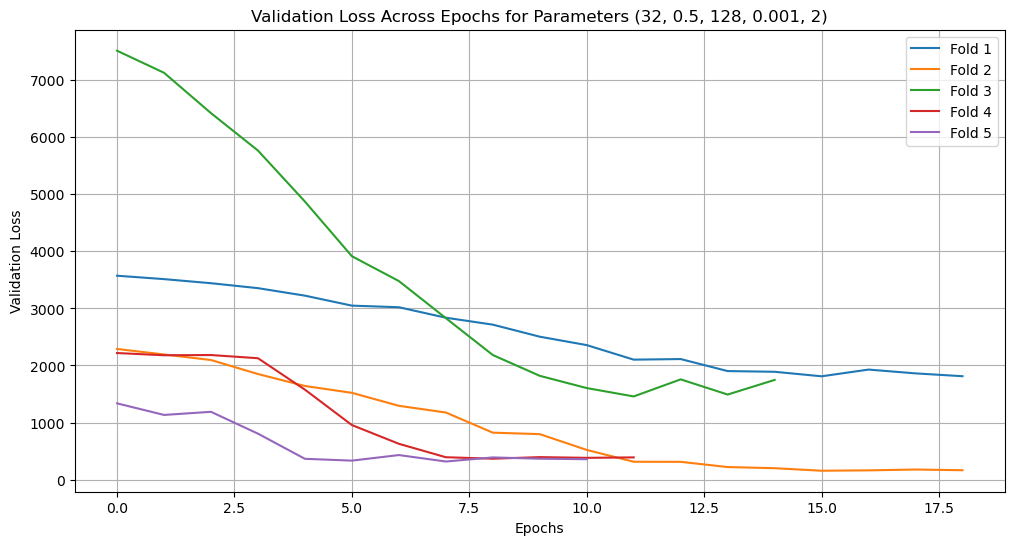

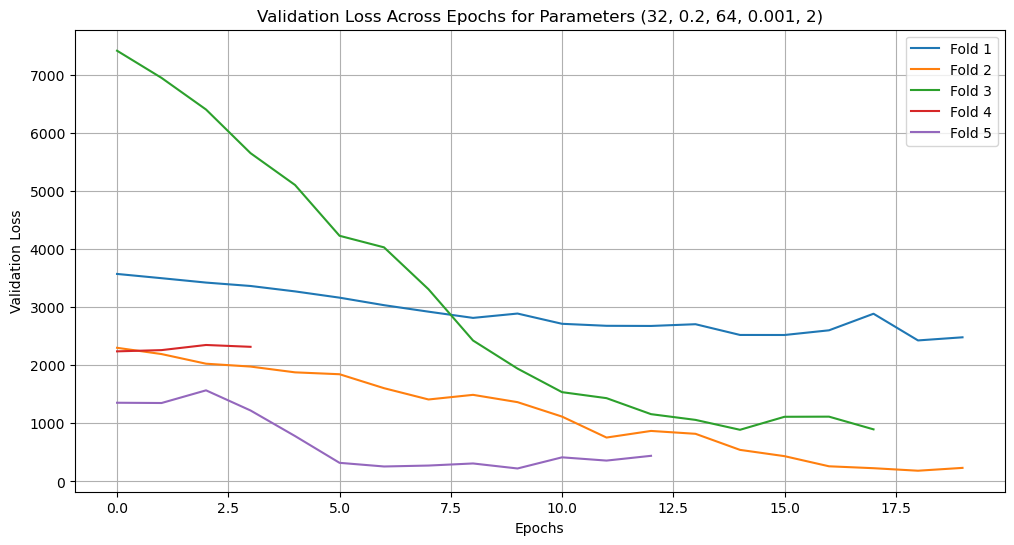

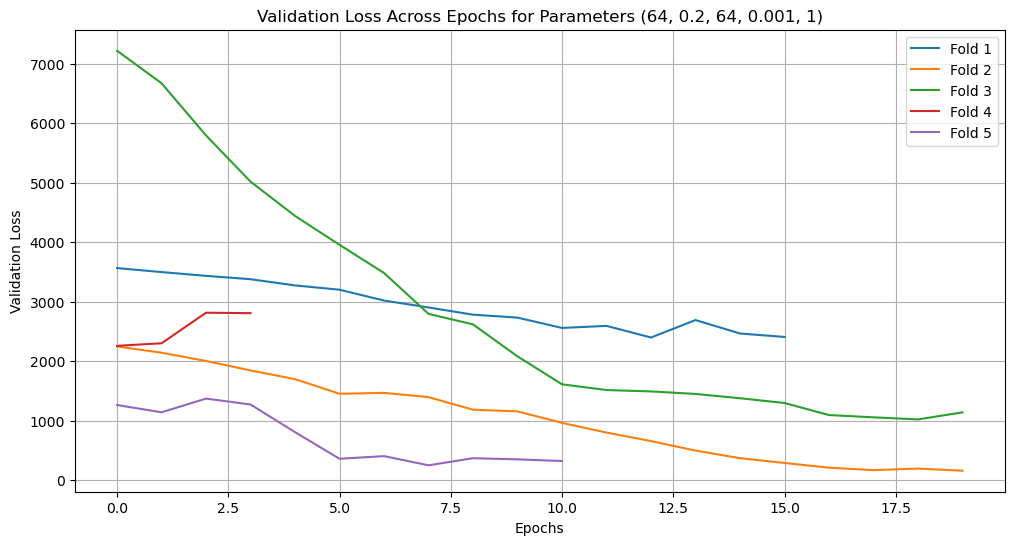

In [44]:
param_grid = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'dense_units': [64, 128, 256],
    'learning_rate': [0.001],
    'num_layers': [1, 2]
}

# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['learning_rate'],
    param_grid['num_layers']
))




# Store results
results = []
validation_loss_tracking = {}


num_samples = 20  
random_combinations = sample(param_combinations, num_samples)

# random_combinations of 20 samples (grid search took too much time)
for params in random_combinations:
    lstm_units, dropout_rate, dense_units, learning_rate, num_layers = params
    print(f"Testing parameters: {params}")
    scores = []
    validation_losses = []

    for train_idx, val_idx in split_indices: #fixed index
        X_train, X_val = seg_7_X_train_lstm[train_idx], seg_7_X_train_lstm[val_idx]
        y_train, y_val = seg_7_y_train_lstm[train_idx], seg_7_y_train_lstm[val_idx]

        # Build model
        model = build_lstm_model(
            input_shape= (X_train.shape[1], X_train.shape[2]),
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            dense_units=dense_units,
            learning_rate=learning_rate,
            num_layers=num_layers
        )
        # Early stopping
        early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Store validation loss per epoch
        validation_losses.append(history.history['val_loss'])

        # Validation predictions
        y_val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        scores.append(mse)

    # Average MSE and validation loss
    avg_score = np.mean(scores)
    avg_val_loss = np.mean([np.mean(losses) for losses in validation_losses])
    results.append({'params': params, 'mse': avg_score})
    validation_loss_tracking[str(params)] = validation_losses

    print(f"Average MSE for parameters {params}: {avg_score}")
    print(f"Average Validation Loss for parameters {params}: {avg_val_loss}")

# Find the best parameters with MSE
best_result = min(results, key=lambda x: x['mse'])
print("\nBest Parameters:")
print(best_result['params'])
print(f"Best Score (MSE): {best_result['mse']}")

# Visualization of results 
mse_values = [result['mse'] for result in results]
labels = [str(result['params']) for result in results]

plt.figure(figsize=(12, 6))
plt.barh(labels, mse_values, color='skyblue')
plt.xlabel('MSE')
plt.ylabel('Hyperparameter Combinations')
plt.title('Hyperparameter Tuning Results (MSE)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Validation Loss Visualization
for params, val_losses in validation_loss_tracking.items():
    plt.figure(figsize=(12, 6))
    for fold, losses in enumerate(val_losses):
        plt.plot(losses, label=f'Fold {fold + 1}')
    plt.title(f'Validation Loss Across Epochs for Parameters {params}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

## Final model for segment 7

Epoch 1/20
115/115 [==============================] - 2s 6ms/step - loss: 2672.4976 - mae: 45.7013
Epoch 2/20
115/115 [==============================] - 1s 7ms/step - loss: 1691.4818 - mae: 37.0574
Epoch 3/20
115/115 [==============================] - 1s 6ms/step - loss: 876.5777 - mae: 25.2365
Epoch 4/20
115/115 [==============================] - 1s 7ms/step - loss: 388.5499 - mae: 14.7124
Epoch 5/20
115/115 [==============================] - 1s 6ms/step - loss: 272.4435 - mae: 11.3840
Epoch 6/20
115/115 [==============================] - 1s 5ms/step - loss: 250.2197 - mae: 10.9322
Epoch 7/20
115/115 [==============================] - 1s 6ms/step - loss: 233.9882 - mae: 10.6951
Epoch 8/20
115/115 [==============================] - 1s 6ms/step - loss: 241.1490 - mae: 10.8767
Epoch 9/20
115/115 [==============================] - 1s 6ms/step - loss: 219.0167 - mae: 10.1941
Epoch 10/20
115/115 [==============================] - 1s 5ms/step - loss: 232.9486 - mae: 10.4027
Epoch 11/20
115/1

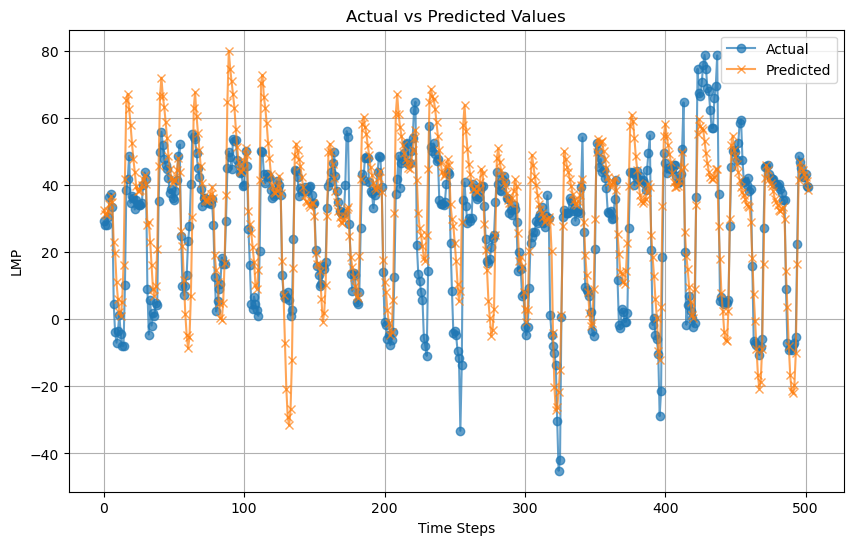

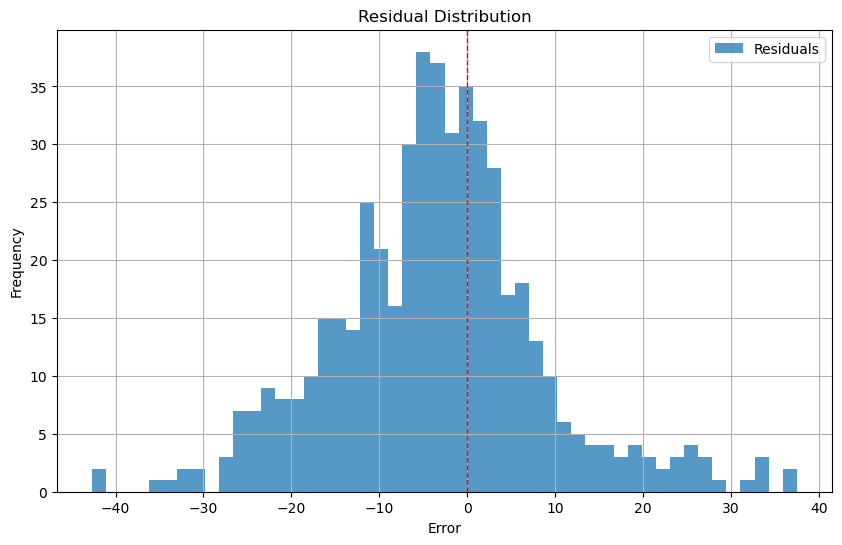

In [35]:

best_params_seg_7 = {
    'lstm_units': 64,
    'dropout_rate': 0.2,
    'dense_units': 256,
    'learning_rate': 0.001,
    'num_layers': 1
}

# Input shape for segment 6
input_shape = (seg_7_X_train_lstm.shape[1], seg_7_X_train_lstm.shape[2])

# Build model using best parameters
model_7 = build_lstm_model(
    input_shape=input_shape,
    lstm_units=best_params_seg_7['lstm_units'],
    dropout_rate=best_params_seg_7['dropout_rate'],
    dense_units=best_params_seg_7['dense_units'],
    learning_rate=best_params_seg_7['learning_rate'],
    num_layers=best_params_seg_7['num_layers']
)


# Train the model on the full training data
history_7 = model_7.fit(
    seg_7_X_train_lstm, seg_7_y_train_lstm,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
seg_7_y_pred = model_7.predict(seg_7_X_test_lstm)

# Calculate MAE and MSE
mae_7 = mean_absolute_error(seg_7_y_test_lstm, seg_7_y_pred)
mse_7 = mean_squared_error(seg_7_y_test_lstm, seg_7_y_pred)

print(f"Mean Absolute Error (MAE): {mae_7}")
print(f"Mean Squared Error (MSE): {mse_7}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(seg_7_y_test_lstm, label='Actual', marker='o', alpha=0.7)
plt.plot(seg_7_y_pred, label='Predicted', marker='x', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('LMP')
plt.grid()
plt.show()

# Residual Analysis
seg_7_residuals = seg_7_y_test_lstm - seg_7_y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(seg_7_residuals, bins=50, alpha=0.75, label='Residuals')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residual Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


# segment 8 model

## segment 8 model parameter tuning

Testing parameters: (32, 0.2, 256, 0.001, 1)
20/20 [==============================] - 0s 1ms/step
Average MSE for parameters (32, 0.2, 256, 0.001, 1): 543.7009698630906
Average Validation Loss for parameters (32, 0.2, 256, 0.001, 1): 1361.4795199706064
Testing parameters: (64, 0.3, 256, 0.001, 1)
20/20 [==============================] - 0s 2ms/step
Average MSE for parameters (64, 0.3, 256, 0.001, 1): 412.11654784448694
Average Validation Loss for parameters (64, 0.3, 256, 0.001, 1): 1310.6288557773166
Testing parameters: (64, 0.3, 128, 0.001, 1)
20/20 [==============================] - 0s 2ms/step
Average MSE for parameters (64, 0.3, 128, 0.001, 1): 548.3003275291105
Average Validation Loss for parameters (64, 0.3, 128, 0.001, 1): 1430.1846230477997
Testing parameters: (32, 0.5, 128, 0.001, 1)
20/20 [==============================] - 0s 1ms/step
Average MSE for parameters (32, 0.5, 128, 0.001, 1): 678.1555525239535
Average Validation Loss for parameters (32, 0.5, 128, 0.001, 1): 1543.4

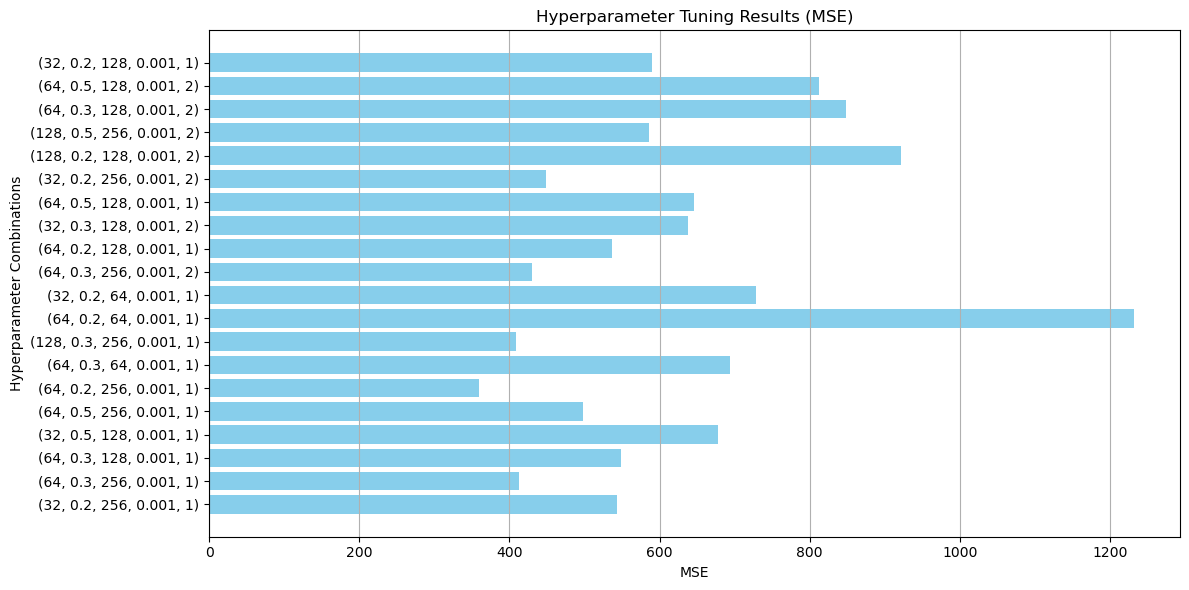

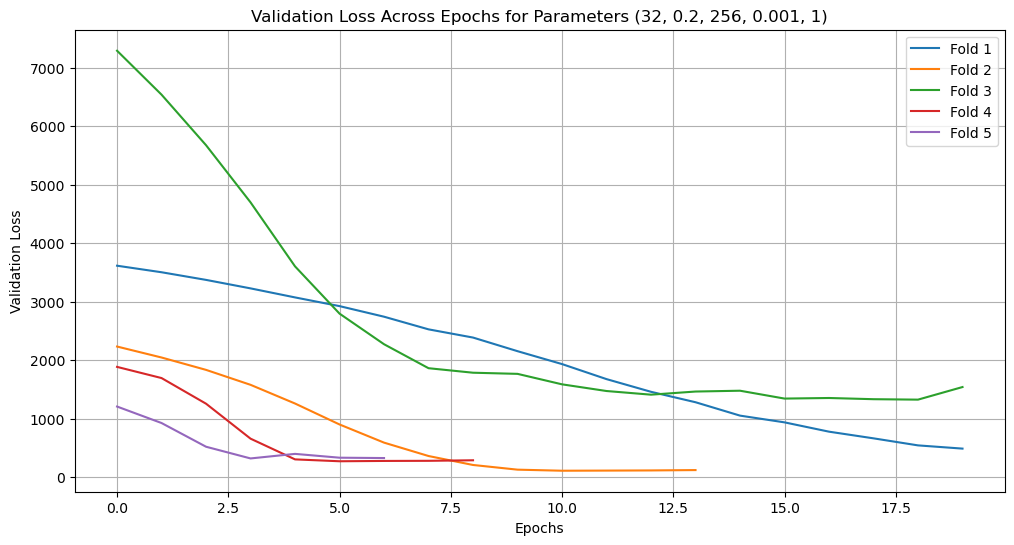

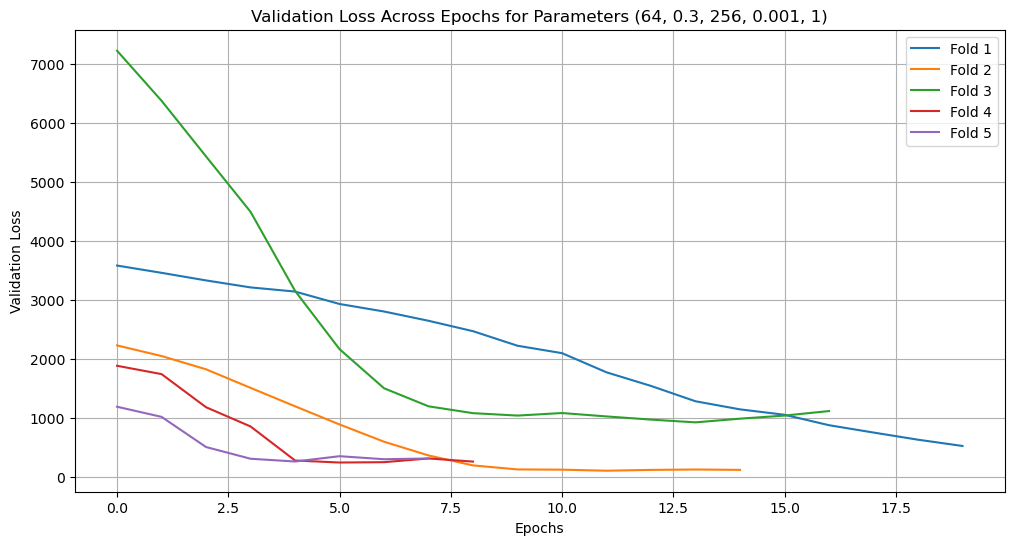

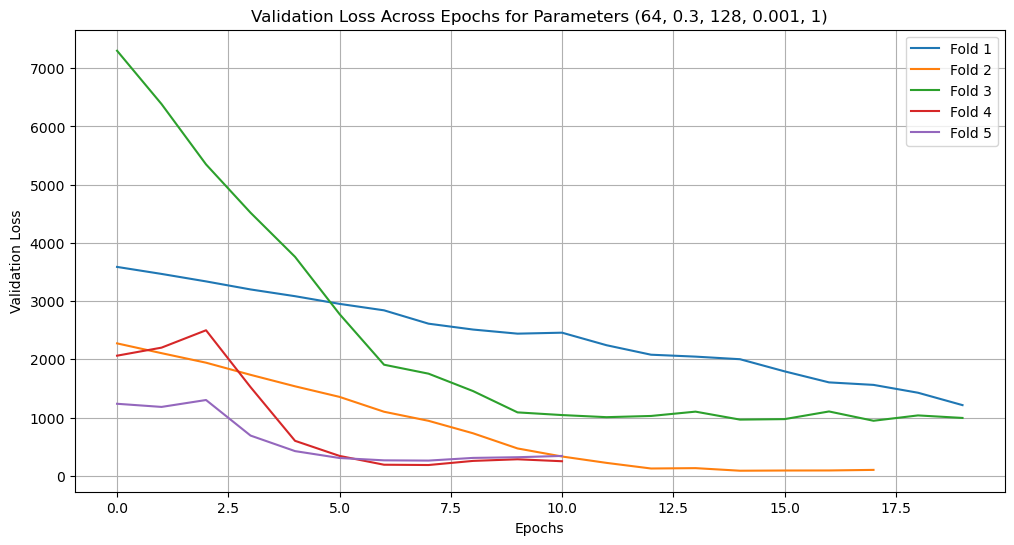

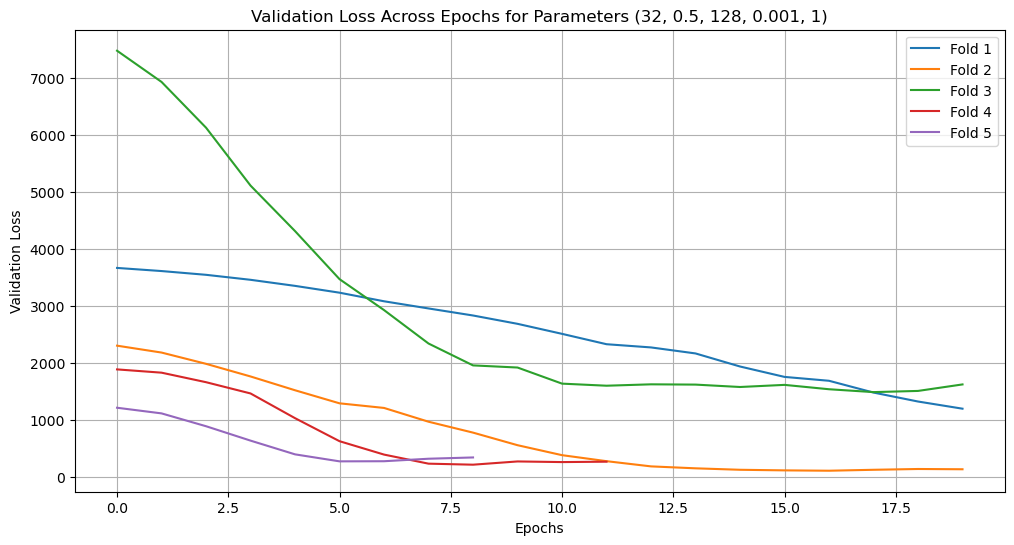

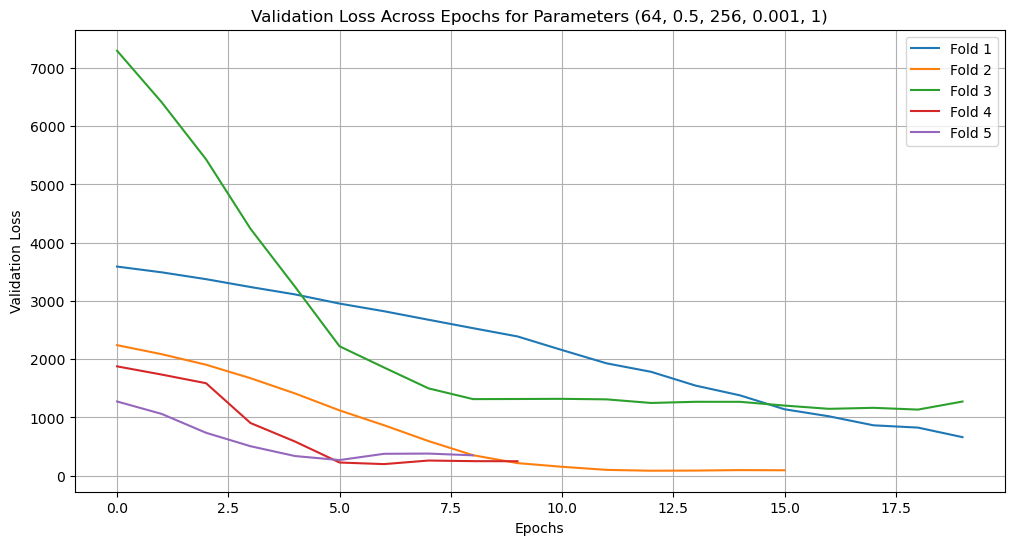

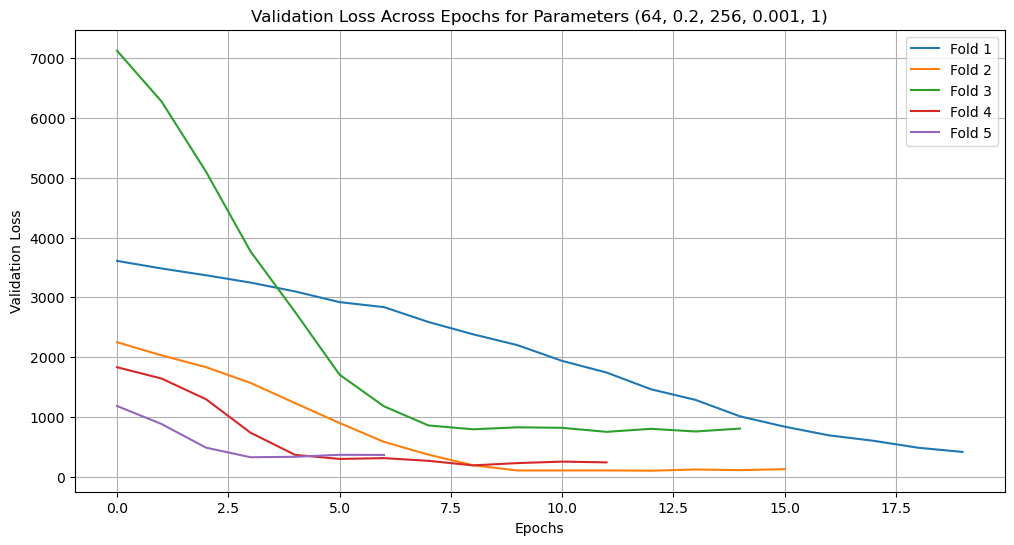

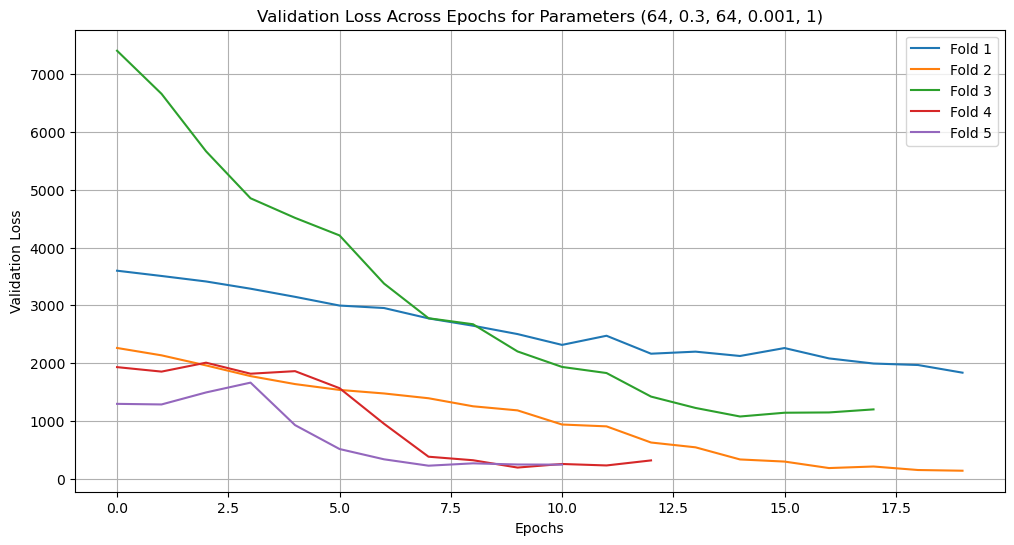

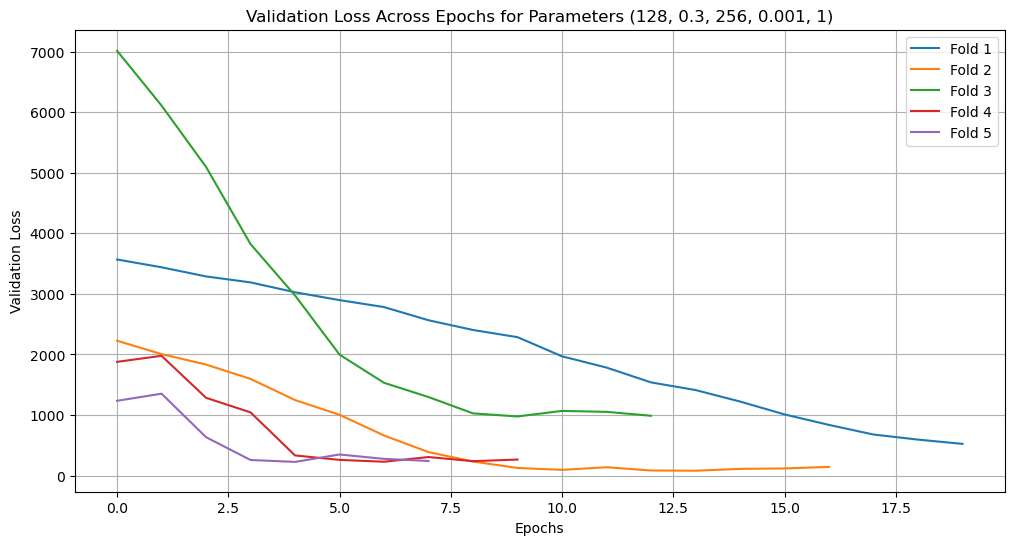

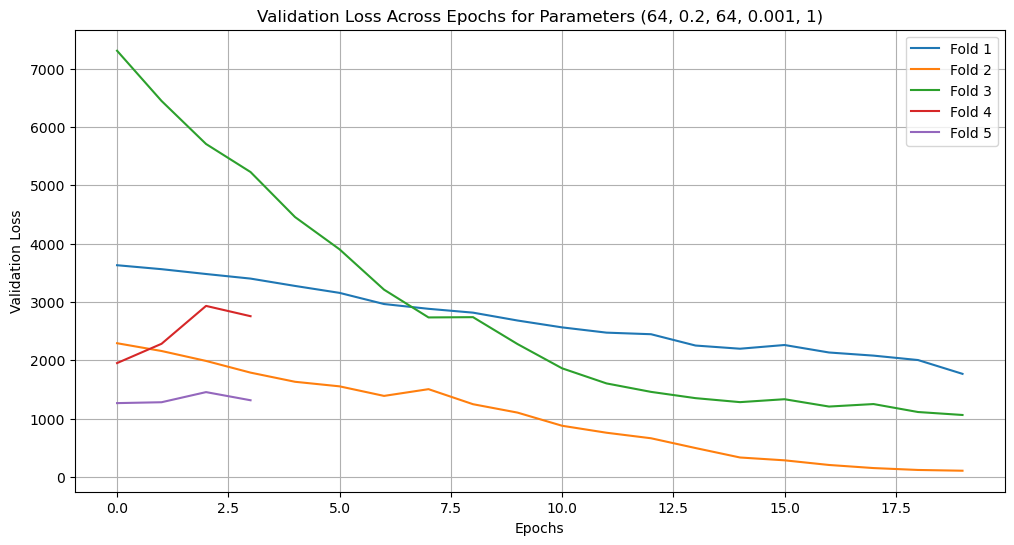

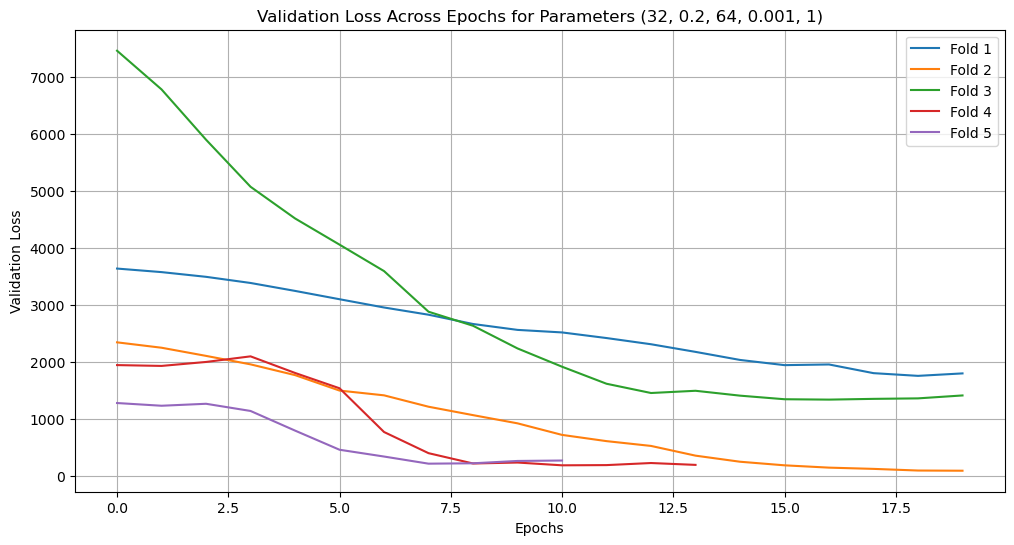

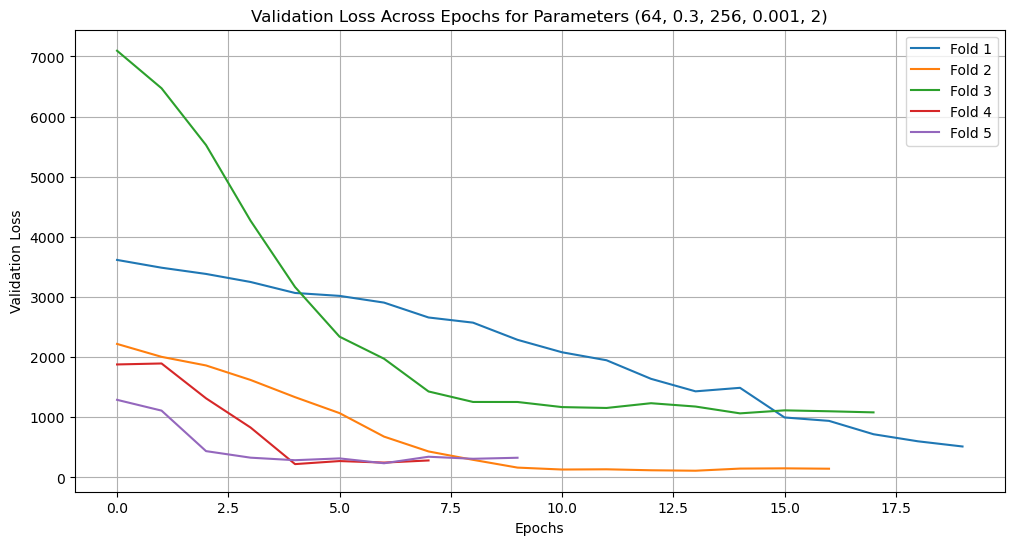

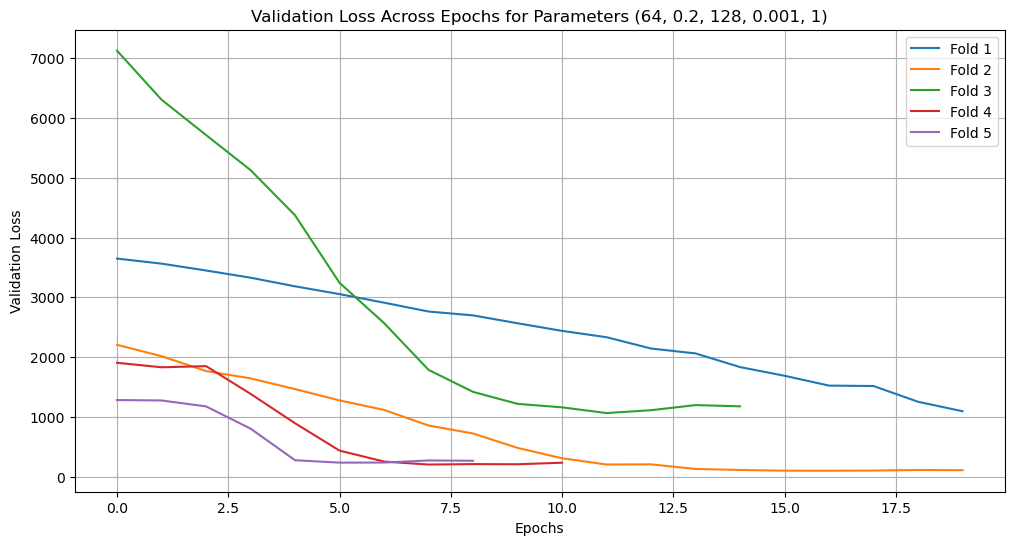

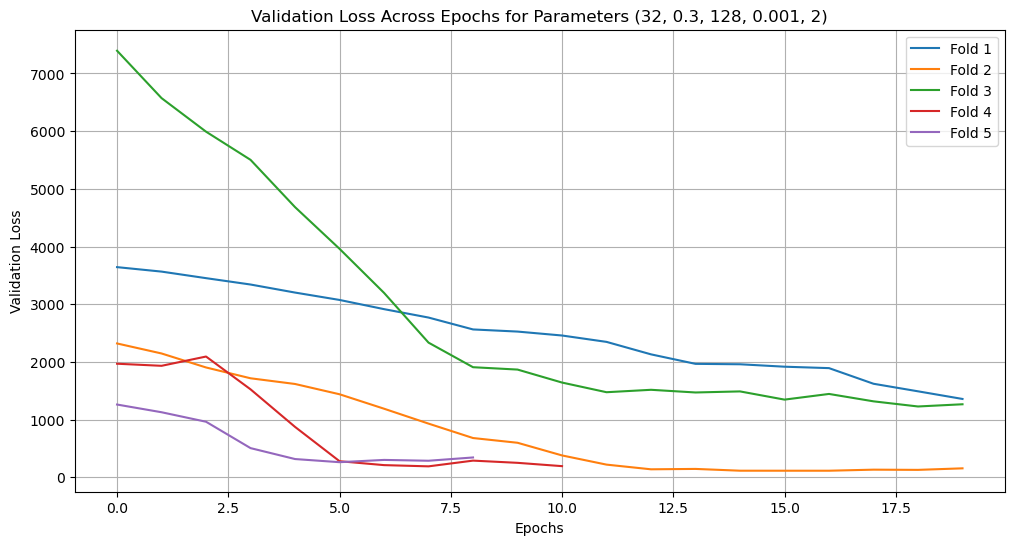

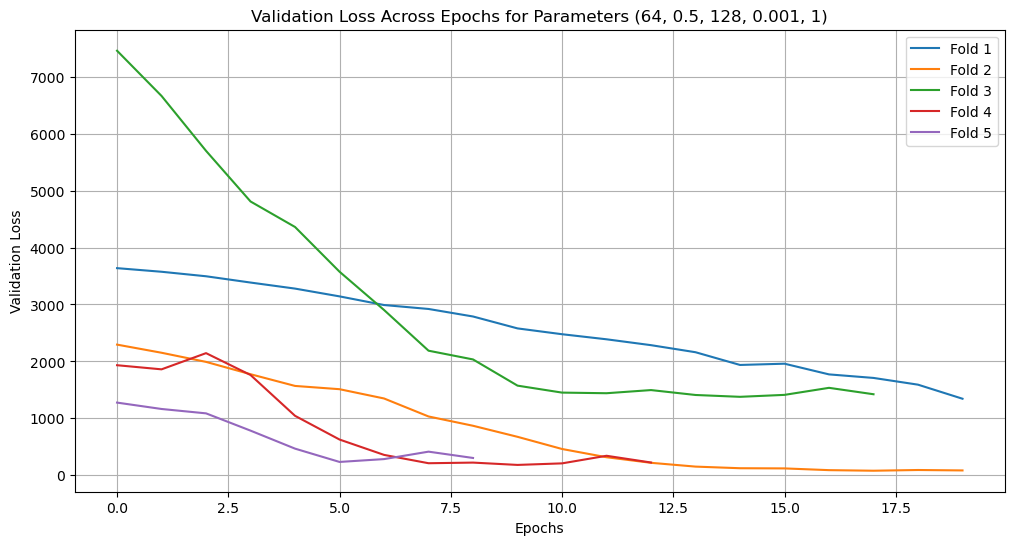

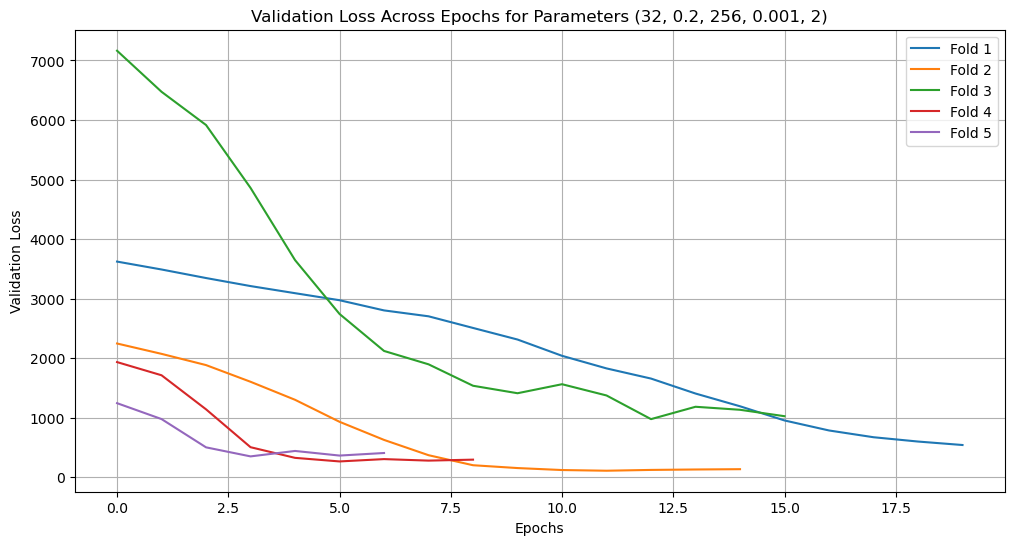

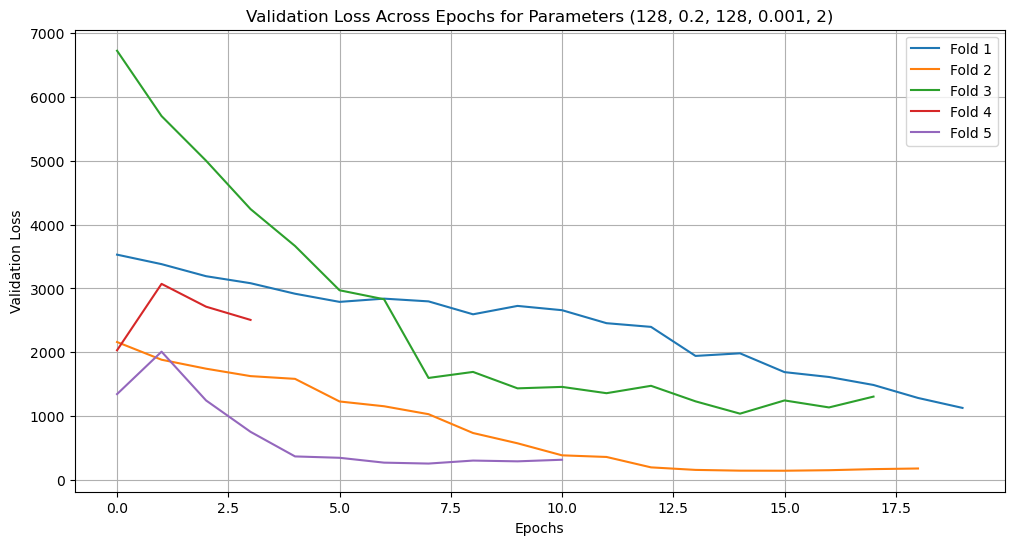

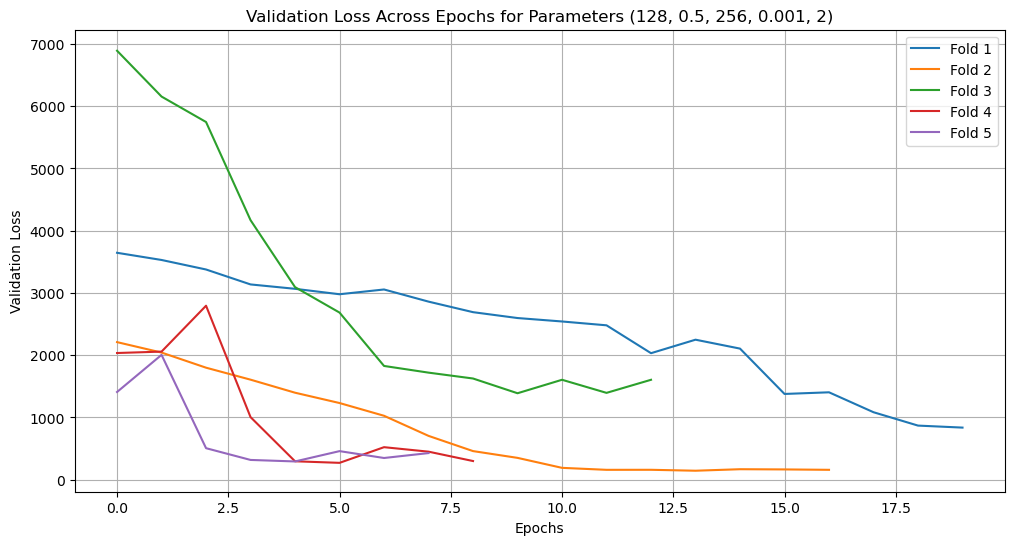

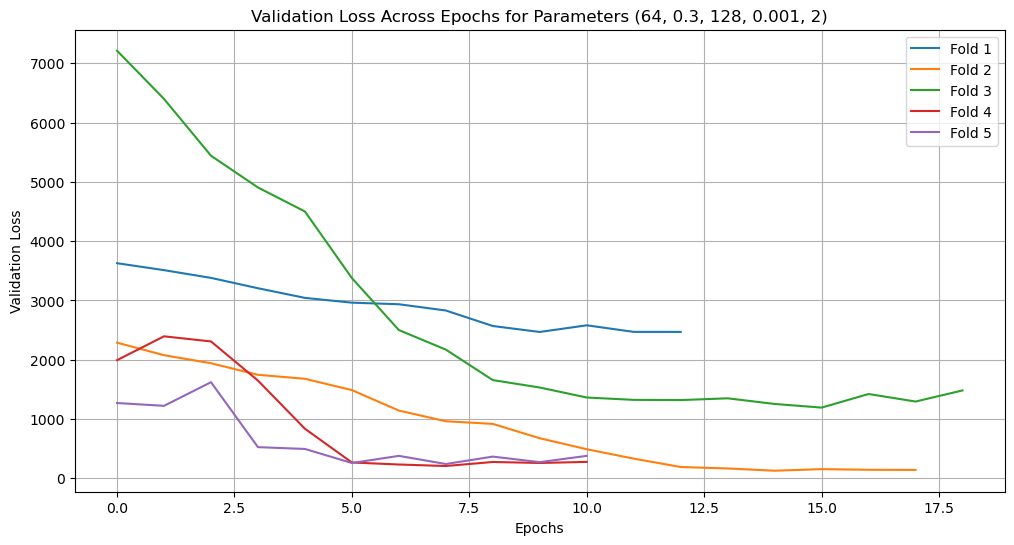

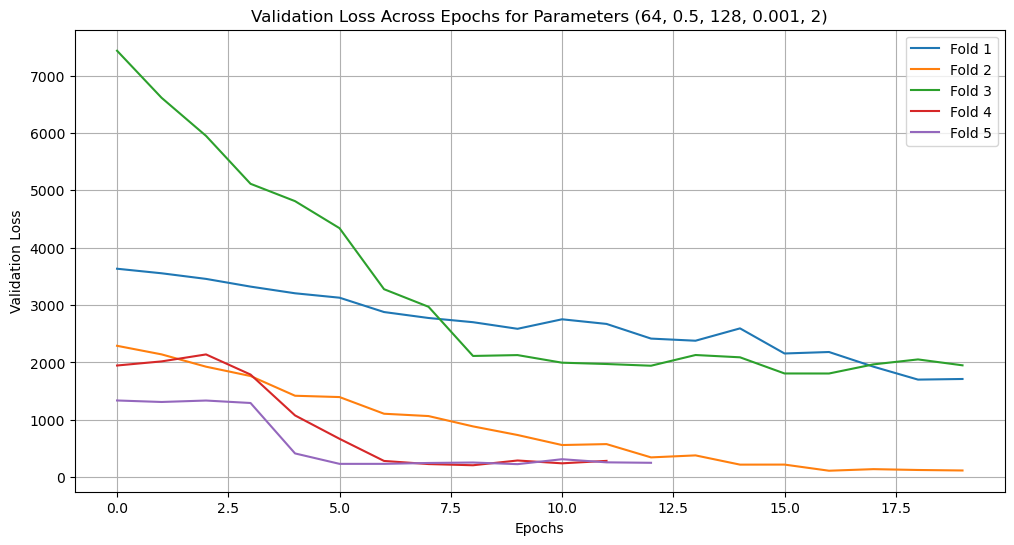

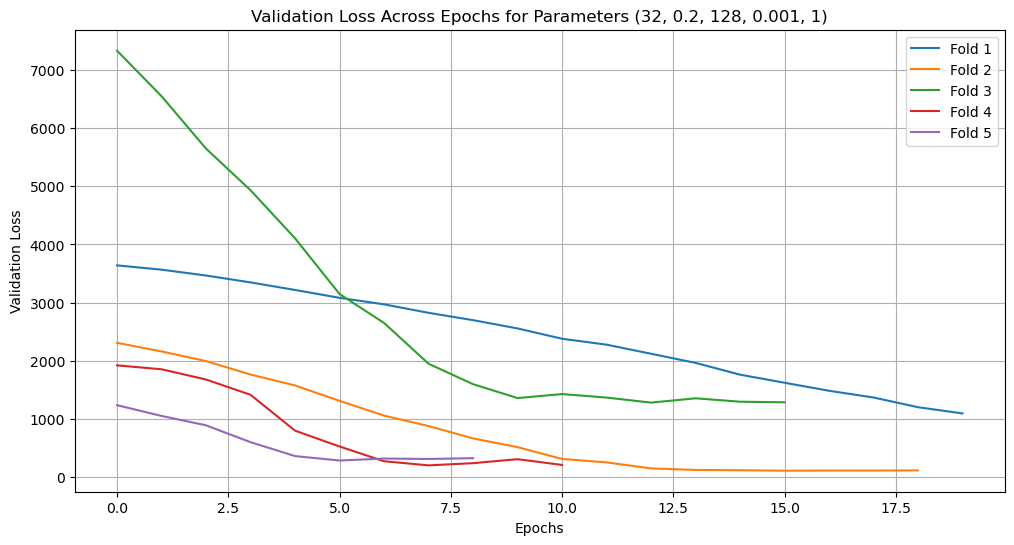

In [10]:
from random import sample

param_grid = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'dense_units': [64, 128, 256],
    'learning_rate': [0.001],
    'num_layers': [1, 2]
}

# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['learning_rate'],
    param_grid['num_layers']
))



# Store results
results = []
validation_loss_tracking = {}


num_samples = 20  
random_combinations = sample(param_combinations, num_samples)

# random_combinations of 20 samples (grid search took too much time)
for params in random_combinations:
    lstm_units, dropout_rate, dense_units, learning_rate, num_layers = params
    print(f"Testing parameters: {params}")
    scores = []
    validation_losses = []

    for train_idx, val_idx in split_indices: #fixed index
        X_train, X_val = seg_8_X_train_lstm[train_idx], seg_8_X_train_lstm[val_idx] #pick corresponding segment 
        y_train, y_val = seg_8_y_train_lstm[train_idx], seg_8_y_train_lstm[val_idx] #pick corresponding segment

        # Build model
        model = build_lstm_model(
            input_shape= (X_train.shape[1], X_train.shape[2]),
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            dense_units=dense_units,
            learning_rate=learning_rate,
            num_layers=num_layers
        )
        # Early stopping
        early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Store validation loss per epoch
        validation_losses.append(history.history['val_loss'])

        # Validation predictions
        y_val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        scores.append(mse)

    # Average MSE and validation loss
    avg_score = np.mean(scores)
    avg_val_loss = np.mean([np.mean(losses) for losses in validation_losses])
    results.append({'params': params, 'mse': avg_score})
    validation_loss_tracking[str(params)] = validation_losses

    print(f"Average MSE for parameters {params}: {avg_score}")
    print(f"Average Validation Loss for parameters {params}: {avg_val_loss}")

# Find the best parameters with MSE
best_result = min(results, key=lambda x: x['mse'])
print("\nBest Parameters:")
print(best_result['params'])
print(f"Best Score (MSE): {best_result['mse']}")

# Visualization of results 
mse_values = [result['mse'] for result in results]
labels = [str(result['params']) for result in results]

plt.figure(figsize=(12, 6))
plt.barh(labels, mse_values, color='skyblue')
plt.xlabel('MSE')
plt.ylabel('Hyperparameter Combinations')
plt.title('Hyperparameter Tuning Results (MSE)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Validation Loss Visualization
for params, val_losses in validation_loss_tracking.items():
    plt.figure(figsize=(12, 6))
    for fold, losses in enumerate(val_losses):
        plt.plot(losses, label=f'Fold {fold + 1}')
    plt.title(f'Validation Loss Across Epochs for Parameters {params}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


## Final modle for segment 8

Epoch 1/20
115/115 [==============================] - 2s 6ms/step - loss: 2583.1838 - mae: 45.6028
Epoch 2/20
115/115 [==============================] - 1s 5ms/step - loss: 1678.3567 - mae: 37.3847
Epoch 3/20
115/115 [==============================] - 1s 5ms/step - loss: 839.5955 - mae: 24.7476
Epoch 4/20
115/115 [==============================] - 1s 5ms/step - loss: 343.0742 - mae: 14.1140
Epoch 5/20
115/115 [==============================] - 1s 5ms/step - loss: 219.1229 - mae: 10.6530
Epoch 6/20
115/115 [==============================] - 1s 5ms/step - loss: 193.7544 - mae: 10.0521
Epoch 7/20
115/115 [==============================] - 1s 5ms/step - loss: 175.1970 - mae: 9.7041
Epoch 8/20
115/115 [==============================] - 1s 6ms/step - loss: 189.7045 - mae: 9.8141
Epoch 9/20
115/115 [==============================] - 1s 6ms/step - loss: 170.9193 - mae: 9.3795
Epoch 10/20
115/115 [==============================] - 1s 5ms/step - loss: 164.7272 - mae: 9.2806
Epoch 11/20
115/115 [

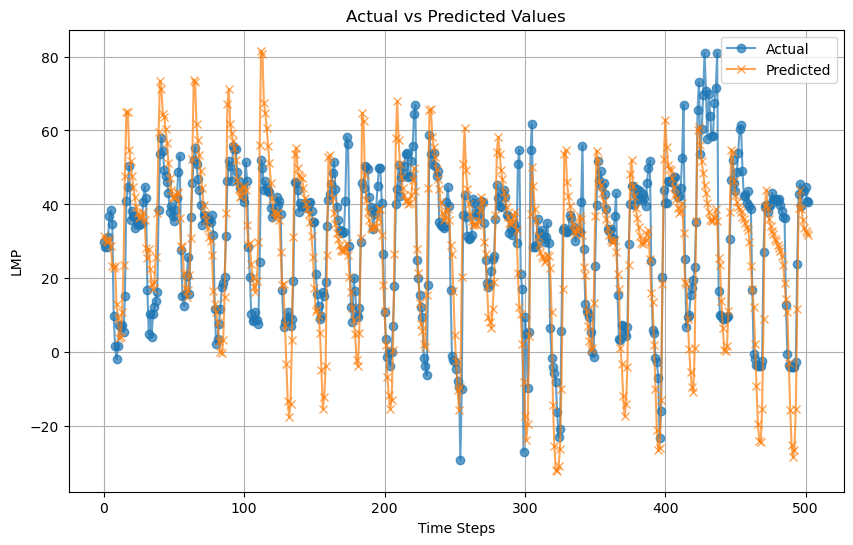

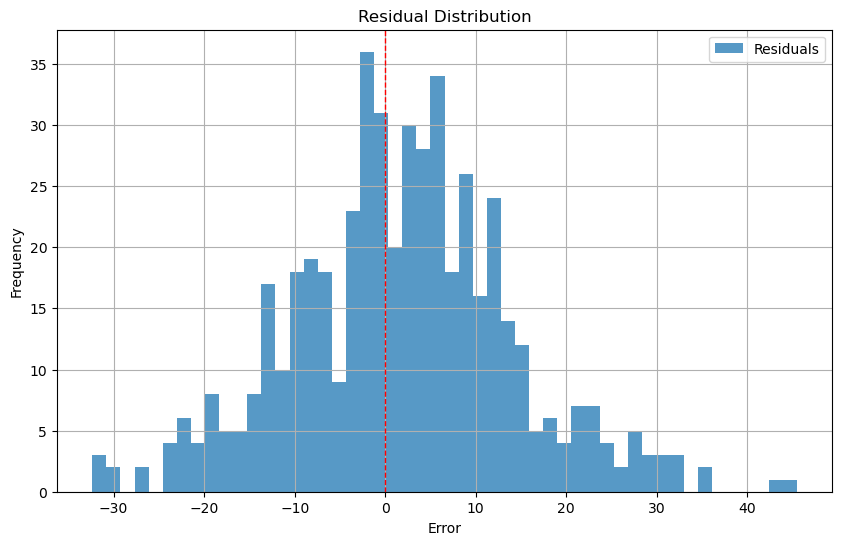

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

best_params_seg_8 = {
    'lstm_units': 64,
    'dropout_rate': 0.2,
    'dense_units': 256,
    'learning_rate': 0.001,
    'num_layers': 1
}

# Input shape for segment 8
input_shape = (seg_8_X_train_lstm.shape[1], seg_8_X_train_lstm.shape[2])

# Build model using best parameters
model_8 = build_lstm_model(
    input_shape=input_shape,
    lstm_units=best_params_seg_8['lstm_units'],
    dropout_rate=best_params_seg_8['dropout_rate'],
    dense_units=best_params_seg_8['dense_units'],
    learning_rate=best_params_seg_8['learning_rate'],
    num_layers=best_params_seg_8['num_layers']
)


# Train the model on the full training data
history_8 = model_8.fit(
    seg_8_X_train_lstm, seg_8_y_train_lstm,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
seg_8_y_pred = model_8.predict(seg_8_X_test_lstm)

# Calculate MAE and MSE
mae_8 = mean_absolute_error(seg_8_y_test_lstm, seg_8_y_pred)
mse_8 = mean_squared_error(seg_8_y_test_lstm, seg_8_y_pred)

print(f"Mean Absolute Error (MAE): {mae_8}")
print(f"Mean Squared Error (MSE): {mse_8}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(seg_8_y_test_lstm, label='Actual', marker='o', alpha=0.7)
plt.plot(seg_8_y_pred, label='Predicted', marker='x', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('LMP')
plt.grid()
plt.show()

# Residual Analysis
seg_8_residuals = seg_8_y_test_lstm - seg_8_y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(seg_8_residuals, bins=50, alpha=0.75, label='Residuals')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residual Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


# segment 9 model

## segment 9 model parameter tuning

Testing parameters: (64, 0.5, 128, 0.001, 1)
20/20 [==============================] - 0s 2ms/step
Average MSE for parameters (64, 0.5, 128, 0.001, 1): 737.4708048313826
Average Validation Loss for parameters (64, 0.5, 128, 0.001, 1): 1629.416565690541
Testing parameters: (32, 0.5, 128, 0.001, 1)
20/20 [==============================] - 0s 1ms/step
Average MSE for parameters (32, 0.5, 128, 0.001, 1): 705.7285948667671
Average Validation Loss for parameters (32, 0.5, 128, 0.001, 1): 1563.065425306378
Testing parameters: (32, 0.5, 256, 0.001, 2)
20/20 [==============================] - 2s 2ms/step
Average MSE for parameters (32, 0.5, 256, 0.001, 2): 704.5104323602307
Average Validation Loss for parameters (32, 0.5, 256, 0.001, 2): 1569.0303682115343
Testing parameters: (32, 0.5, 128, 0.001, 2)
20/20 [==============================] - 0s 2ms/step
Average MSE for parameters (32, 0.5, 128, 0.001, 2): 816.1998778094976
Average Validation Loss for parameters (32, 0.5, 128, 0.001, 2): 1655.8925

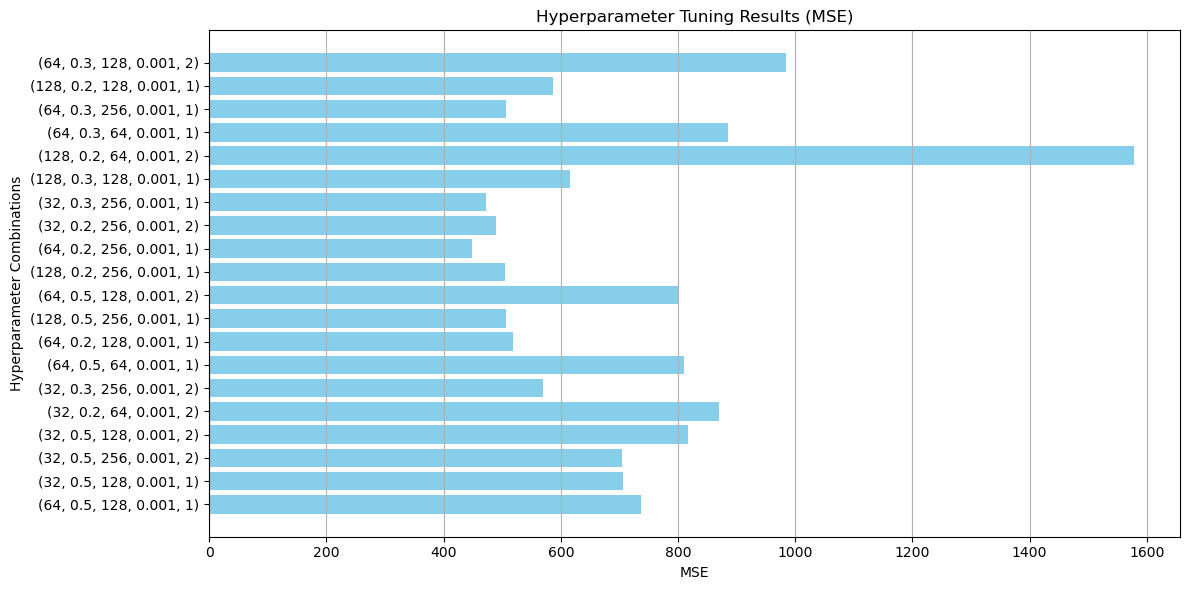

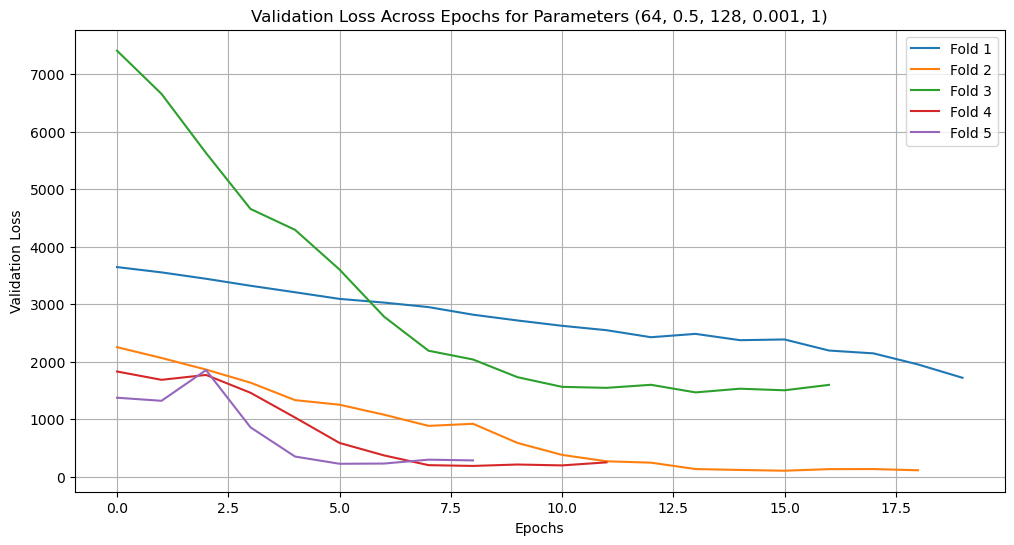

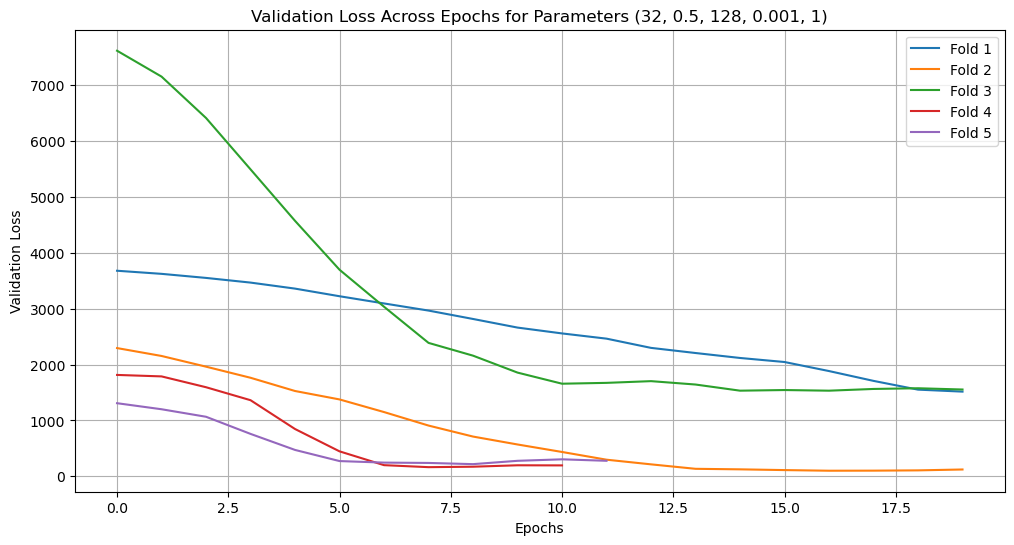

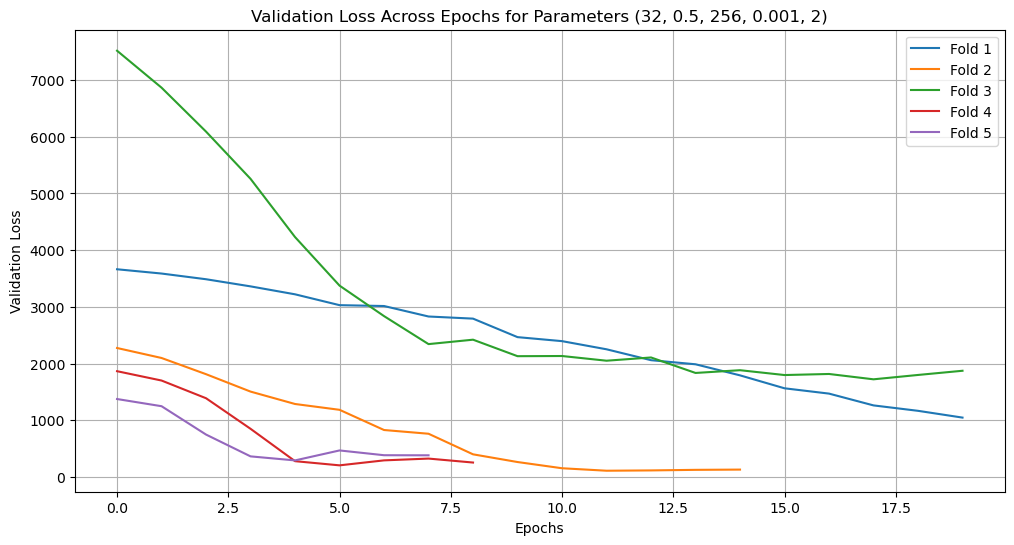

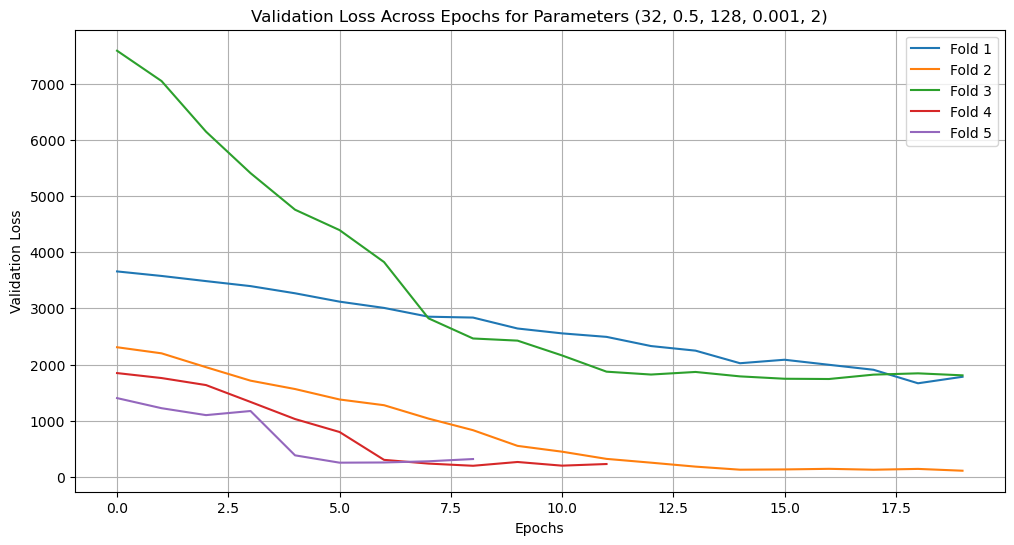

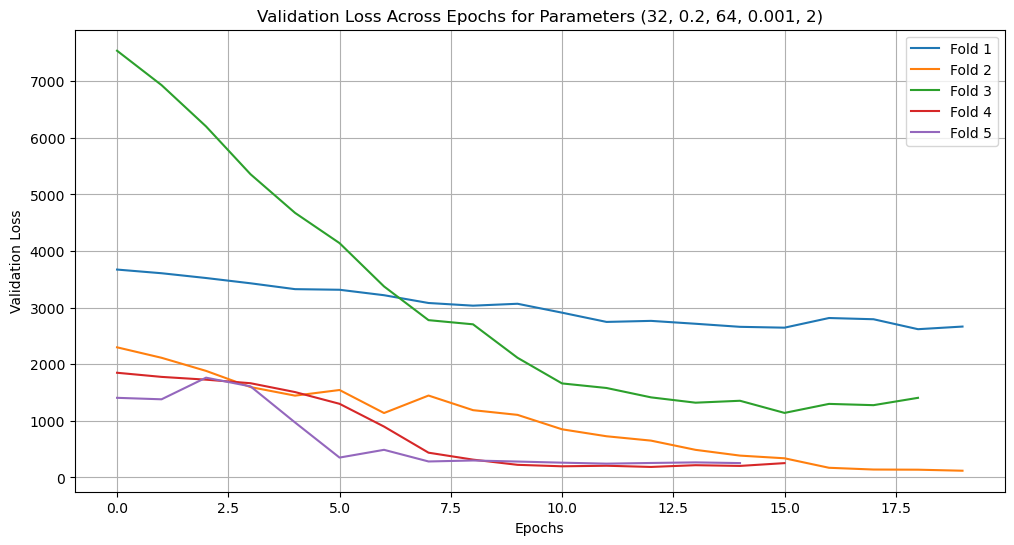

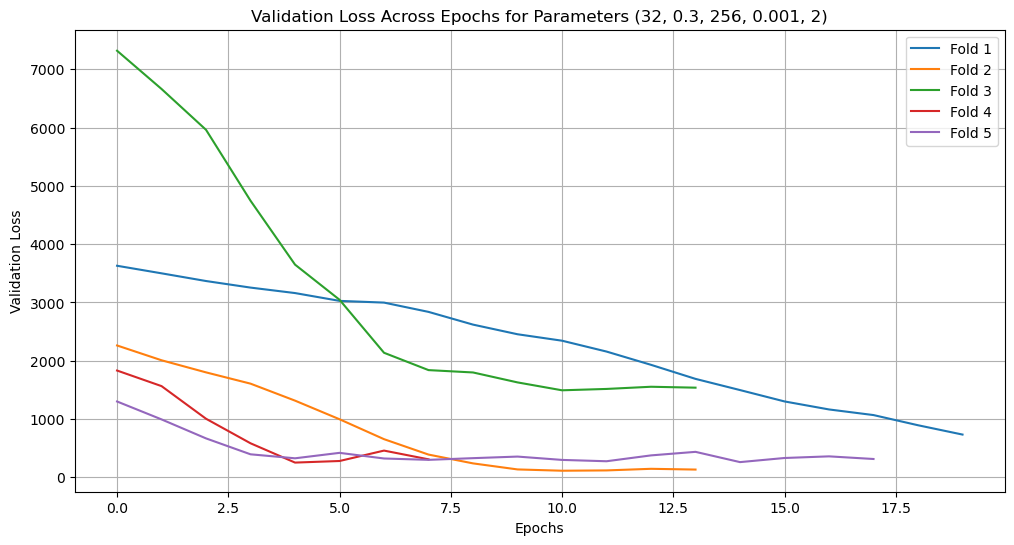

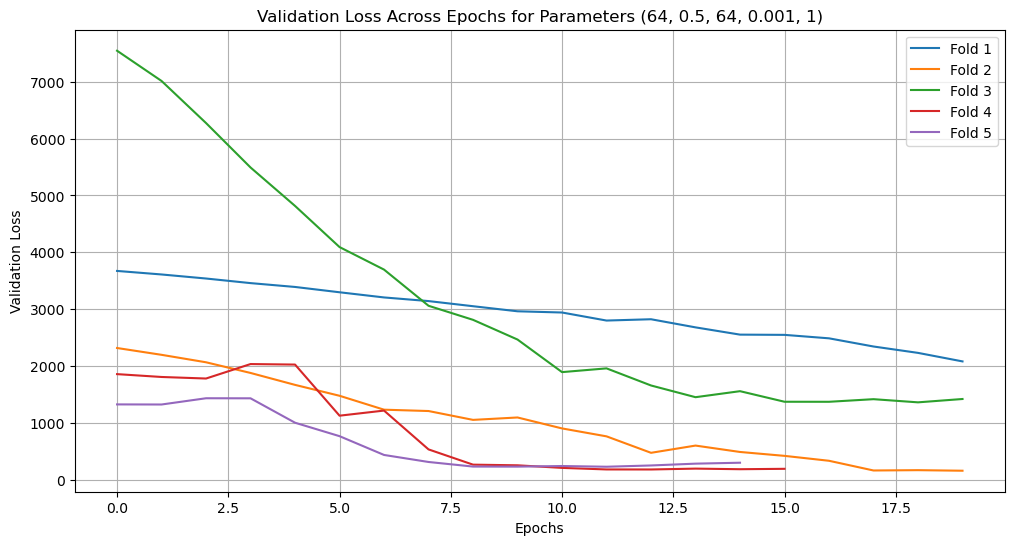

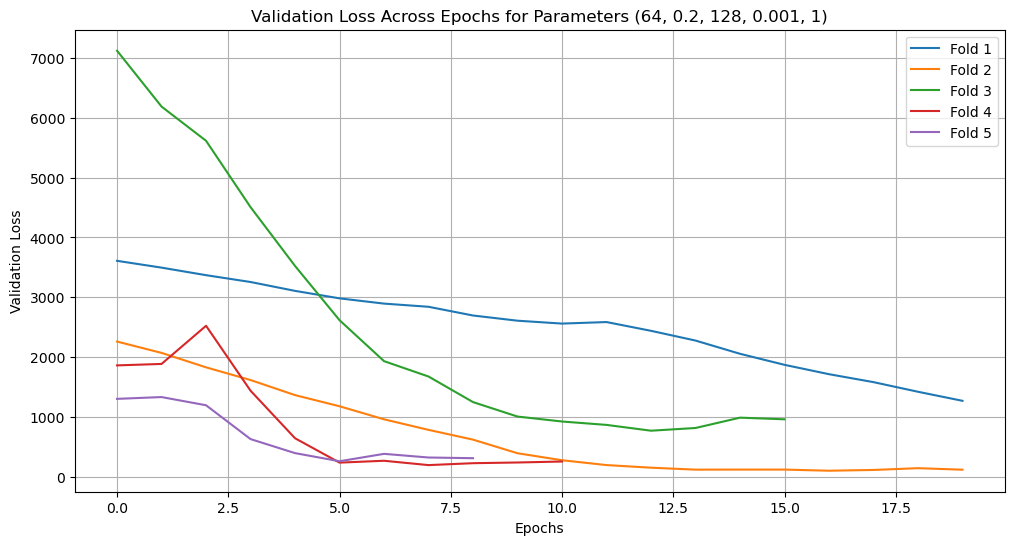

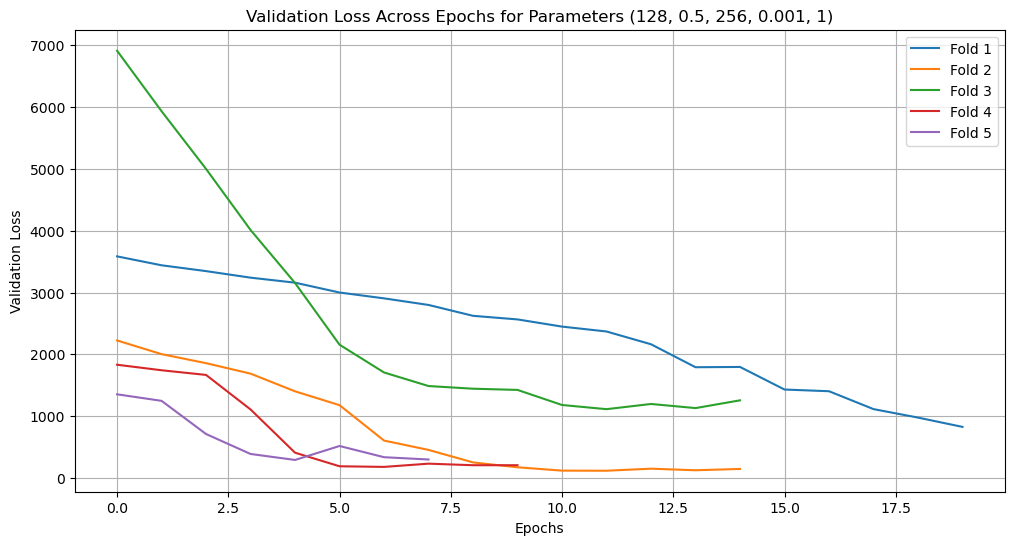

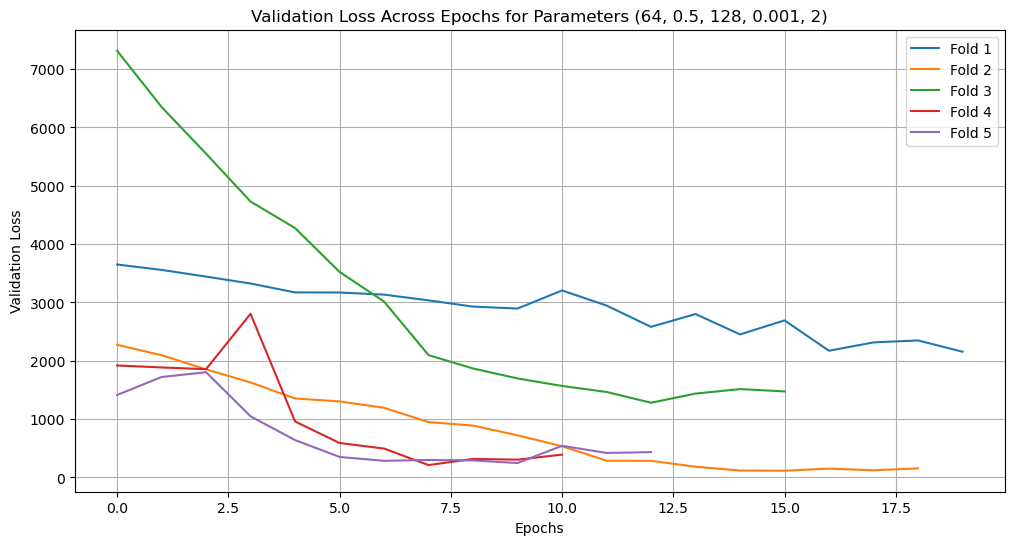

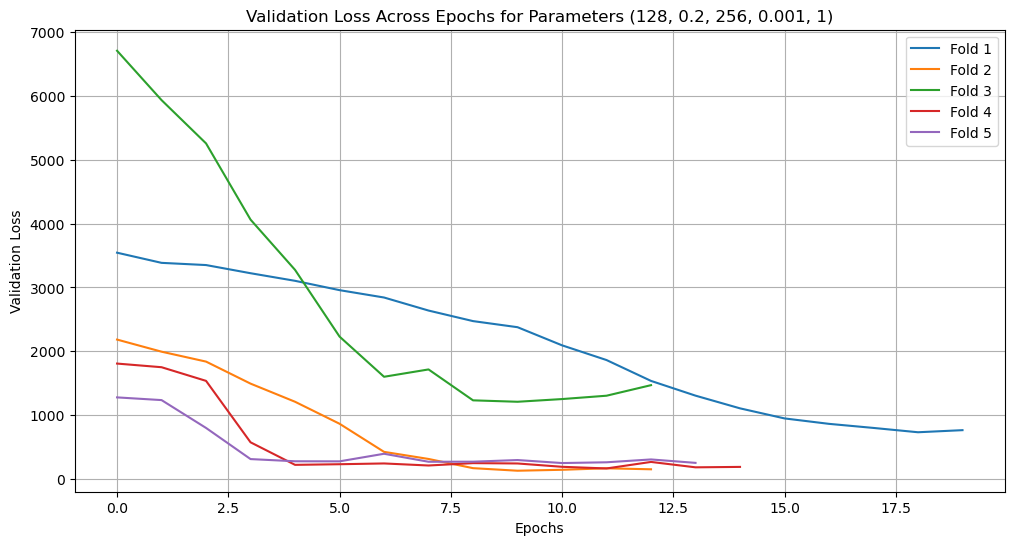

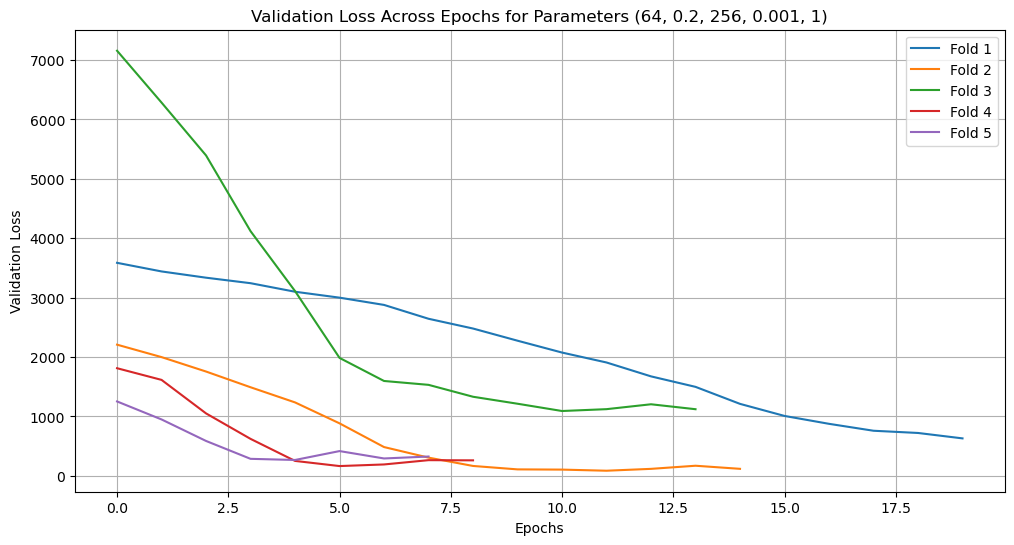

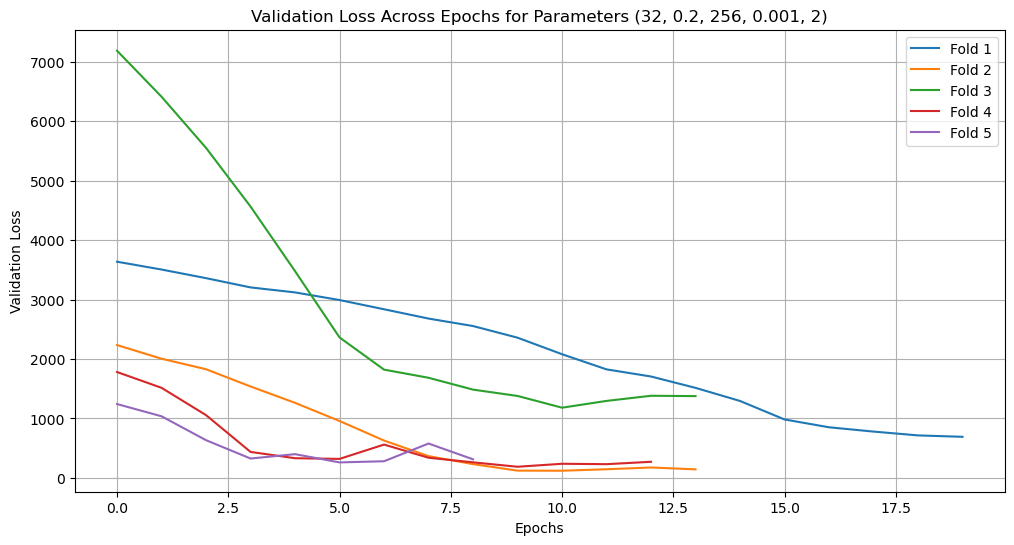

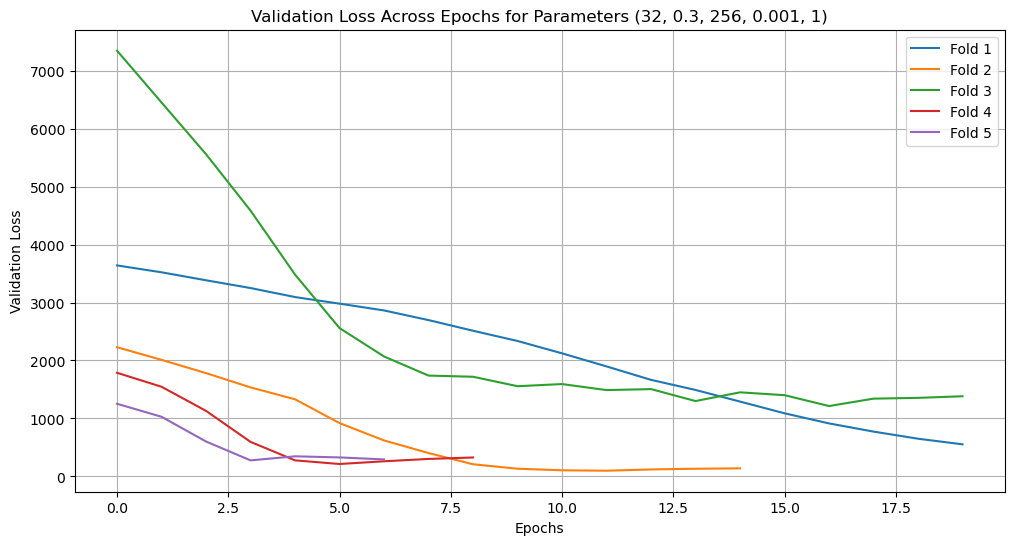

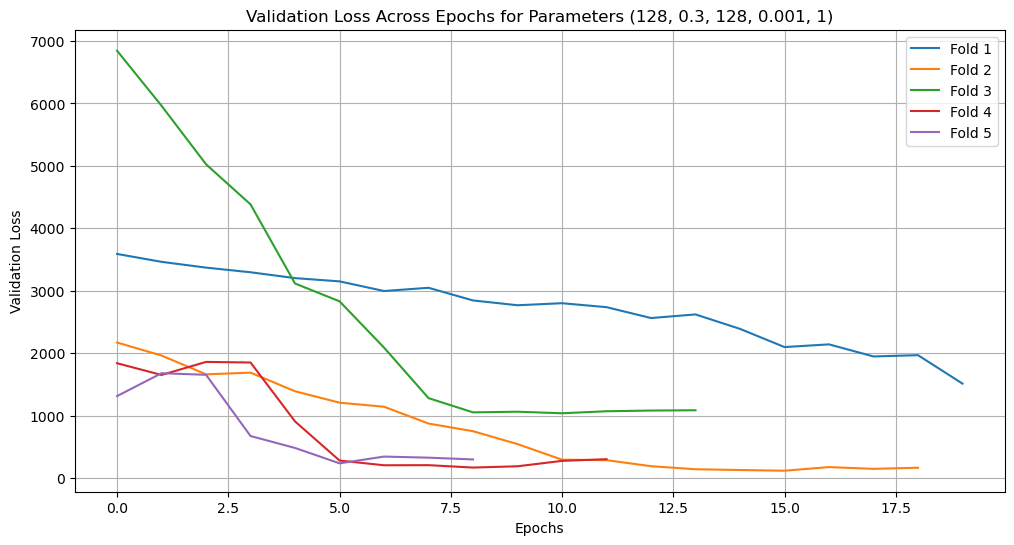

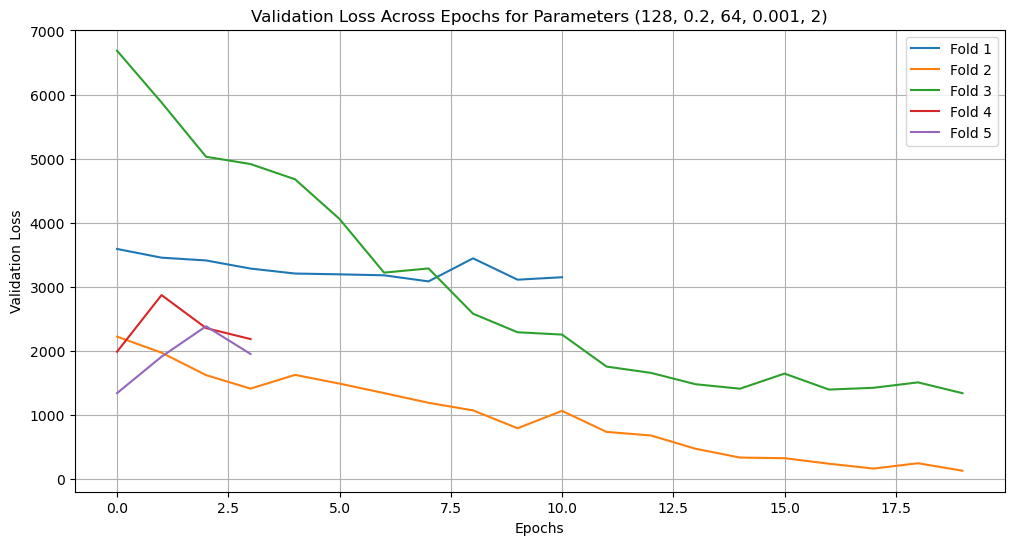

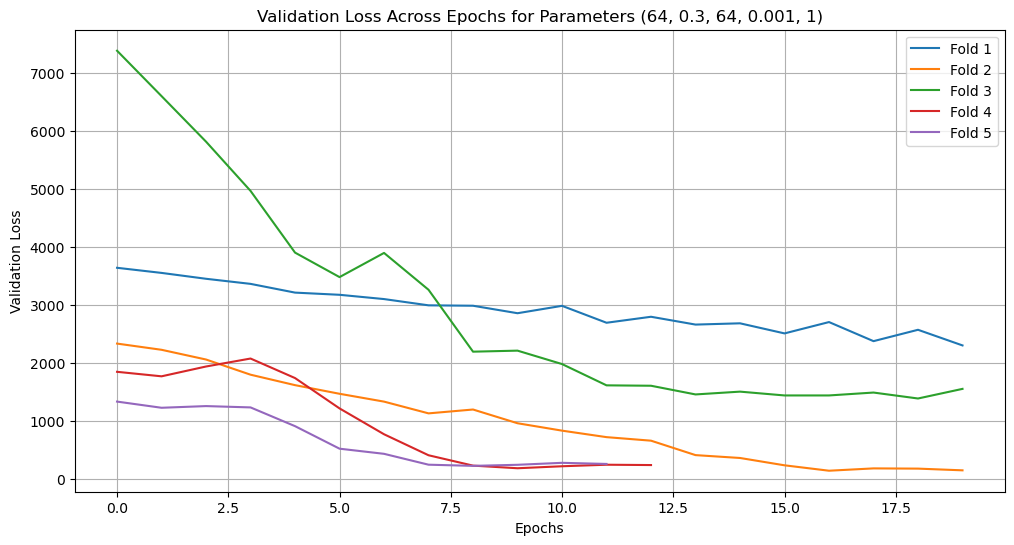

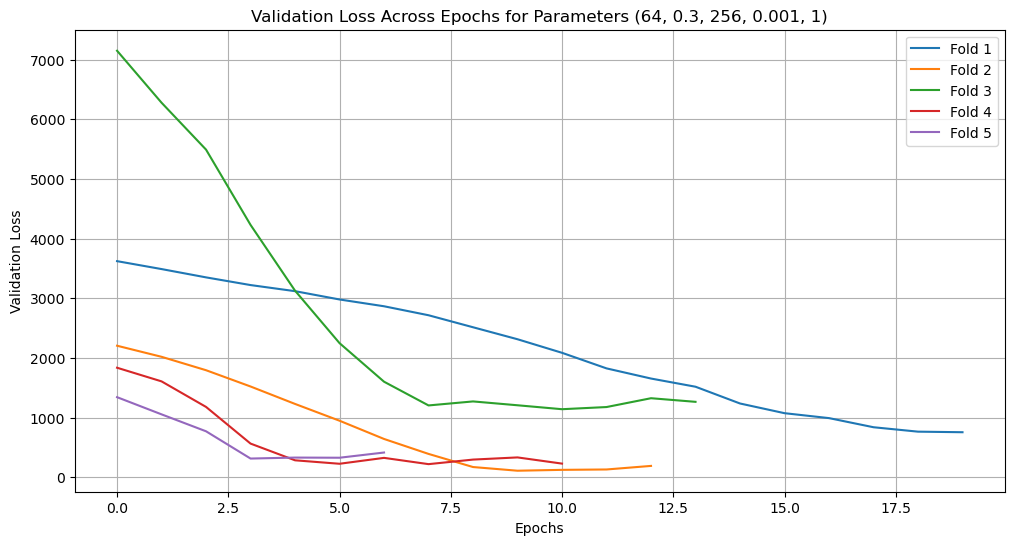

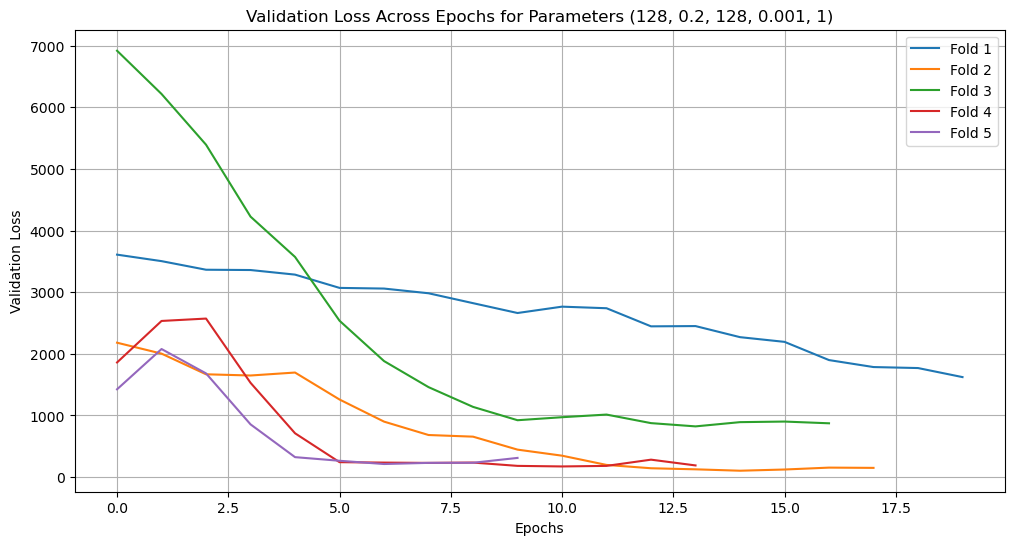

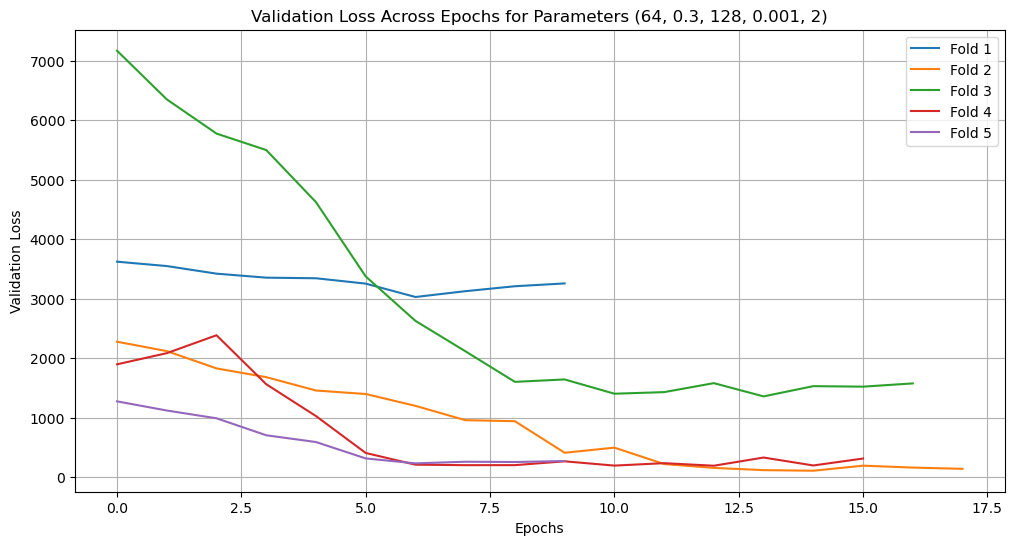

In [15]:
param_grid = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'dense_units': [64, 128, 256],
    'learning_rate': [0.001],
    'num_layers': [1, 2]
}

# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['dropout_rate'],
    param_grid['dense_units'],
    param_grid['learning_rate'],
    param_grid['num_layers']
))



# Store results
results = []
validation_loss_tracking = {}


num_samples = 20  
random_combinations = sample(param_combinations, num_samples)

# random_combinations of 20 samples (grid search took too much time)
for params in random_combinations:
    lstm_units, dropout_rate, dense_units, learning_rate, num_layers = params
    print(f"Testing parameters: {params}")
    scores = []
    validation_losses = []

    for train_idx, val_idx in split_indices: #fixed index
        X_train, X_val = seg_9_X_train_lstm[train_idx], seg_9_X_train_lstm[val_idx] #pick corresponding segment 
        y_train, y_val = seg_9_y_train_lstm[train_idx], seg_9_y_train_lstm[val_idx] #pick corresponding segment

        # Build model
        model = build_lstm_model(
            input_shape= (X_train.shape[1], X_train.shape[2]),
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            dense_units=dense_units,
            learning_rate=learning_rate,
            num_layers=num_layers
        )
        # Early stopping
        early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

        # Model checkpoint
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            verbose=0
        )
        
        # Store validation loss per epoch
        validation_losses.append(history.history['val_loss'])

        # Validation predictions
        y_val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        scores.append(mse)

    # Average MSE and validation loss
    avg_score = np.mean(scores)
    avg_val_loss = np.mean([np.mean(losses) for losses in validation_losses])
    results.append({'params': params, 'mse': avg_score})
    validation_loss_tracking[str(params)] = validation_losses

    print(f"Average MSE for parameters {params}: {avg_score}")
    print(f"Average Validation Loss for parameters {params}: {avg_val_loss}")

# Find the best parameters with MSE
best_result = min(results, key=lambda x: x['mse'])
print("\nBest Parameters:")
print(best_result['params'])
print(f"Best Score (MSE): {best_result['mse']}")

# Visualization of results 
mse_values = [result['mse'] for result in results]
labels = [str(result['params']) for result in results]

plt.figure(figsize=(12, 6))
plt.barh(labels, mse_values, color='skyblue')
plt.xlabel('MSE')
plt.ylabel('Hyperparameter Combinations')
plt.title('Hyperparameter Tuning Results (MSE)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Validation Loss Visualization
for params, val_losses in validation_loss_tracking.items():
    plt.figure(figsize=(12, 6))
    for fold, losses in enumerate(val_losses):
        plt.plot(losses, label=f'Fold {fold + 1}')
    plt.title(f'Validation Loss Across Epochs for Parameters {params}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

## Final model for segment 9

Epoch 1/20
115/115 [==============================] - 2s 6ms/step - loss: 2632.0762 - mae: 45.7629
Epoch 2/20
115/115 [==============================] - 1s 5ms/step - loss: 1712.8721 - mae: 37.5740
Epoch 3/20
115/115 [==============================] - 1s 5ms/step - loss: 848.1351 - mae: 25.1191
Epoch 4/20
115/115 [==============================] - 1s 5ms/step - loss: 341.1768 - mae: 14.1095
Epoch 5/20
115/115 [==============================] - 1s 5ms/step - loss: 222.5045 - mae: 10.8133
Epoch 6/20
115/115 [==============================] - 1s 5ms/step - loss: 201.0870 - mae: 10.2257
Epoch 7/20
115/115 [==============================] - 1s 5ms/step - loss: 191.8332 - mae: 10.1252
Epoch 8/20
115/115 [==============================] - 1s 5ms/step - loss: 173.6731 - mae: 9.6415
Epoch 9/20
115/115 [==============================] - 1s 5ms/step - loss: 177.0119 - mae: 9.7409
Epoch 10/20
115/115 [==============================] - 1s 6ms/step - loss: 159.1972 - mae: 9.0153
Epoch 11/20
115/115 

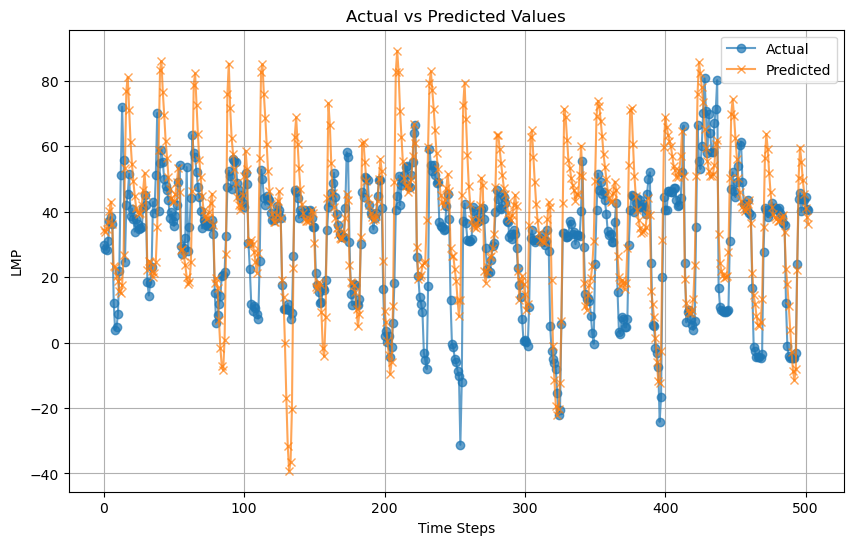

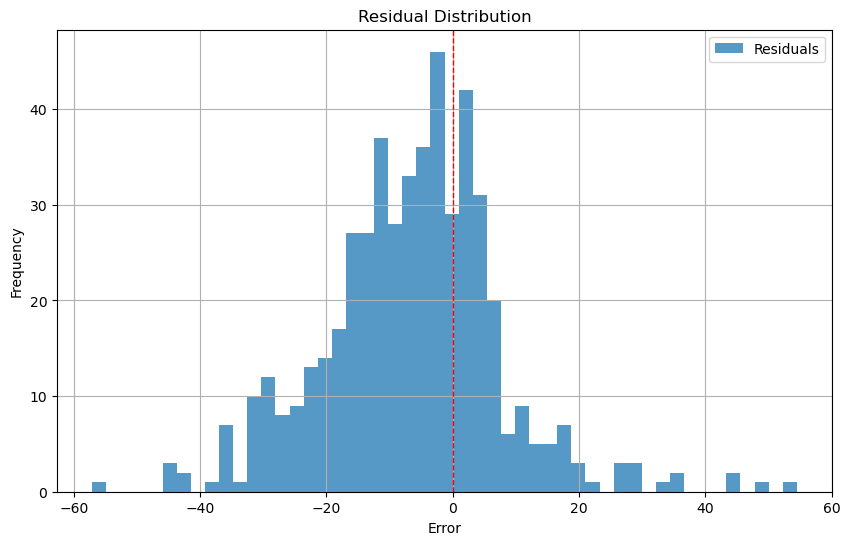

In [37]:

best_params_seg_9 = {
    'lstm_units': 64,
    'dropout_rate': 0.2,
    'dense_units': 256,
    'learning_rate': 0.001,
    'num_layers': 1
}

# Input shape for segment 9
input_shape = (seg_9_X_train_lstm.shape[1], seg_9_X_train_lstm.shape[2])

# Build model using best parameters
model_9 = build_lstm_model(
    input_shape=input_shape,
    lstm_units=best_params_seg_9['lstm_units'],
    dropout_rate=best_params_seg_9['dropout_rate'],
    dense_units=best_params_seg_9['dense_units'],
    learning_rate=best_params_seg_9['learning_rate'],
    num_layers=best_params_seg_9['num_layers']
)


# Train the model on the full training data
history_9 = model_9.fit(
    seg_9_X_train_lstm, seg_9_y_train_lstm,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on test data
seg_9_y_pred = model_9.predict(seg_9_X_test_lstm)

# Calculate MAE and MSE
mae_9 = mean_absolute_error(seg_9_y_test_lstm, seg_9_y_pred)
mse_9 = mean_squared_error(seg_9_y_test_lstm, seg_9_y_pred)

print(f"Mean Absolute Error (MAE): {mae_9}")
print(f"Mean Squared Error (MSE): {mse_9}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(seg_9_y_test_lstm, label='Actual', marker='o', alpha=0.7)
plt.plot(seg_9_y_pred, label='Predicted', marker='x', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('LMP')
plt.grid()
plt.show()

# Residual Analysis
seg_9_residuals = seg_9_y_test_lstm - seg_9_y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(seg_9_residuals, bins=50, alpha=0.75, label='Residuals')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title('Residual Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


# Performance Comparison

In [38]:
from matplotlib.dates import DateFormatter, DayLocator

# Create the DataFrame with predictions
time_steps = 24
prediction_df_6 = pd.DataFrame({
    'Time': pd.to_datetime(seg_6_test['Time'].iloc[time_steps:].reset_index(drop=True)),  # Ensure Time is datetime
    'Actual': seg_6_y_test_lstm.flatten(),
    'Predicted': seg_6_y_pred.flatten()
})


prediction_df_7 = pd.DataFrame({
    'Time': pd.to_datetime(seg_7_test['Time'].iloc[time_steps:].reset_index(drop=True)),  # Ensure Time is datetime
    'Actual': seg_7_y_test_lstm.flatten(),
    'Predicted': seg_7_y_pred.flatten()
})

prediction_df_8 = pd.DataFrame({
    'Time': pd.to_datetime(seg_8_test['Time'].iloc[time_steps:].reset_index(drop=True)),  # Ensure Time is datetime
    'Actual': seg_8_y_test_lstm.flatten(),
    'Predicted': seg_8_y_pred.flatten()
})


prediction_df_9 = pd.DataFrame({
    'Time': pd.to_datetime(seg_9_test['Time'].iloc[time_steps:].reset_index(drop=True)),  # Ensure Time is datetime
    'Actual': seg_9_y_test_lstm.flatten(),
    'Predicted': seg_9_y_pred.flatten()
})


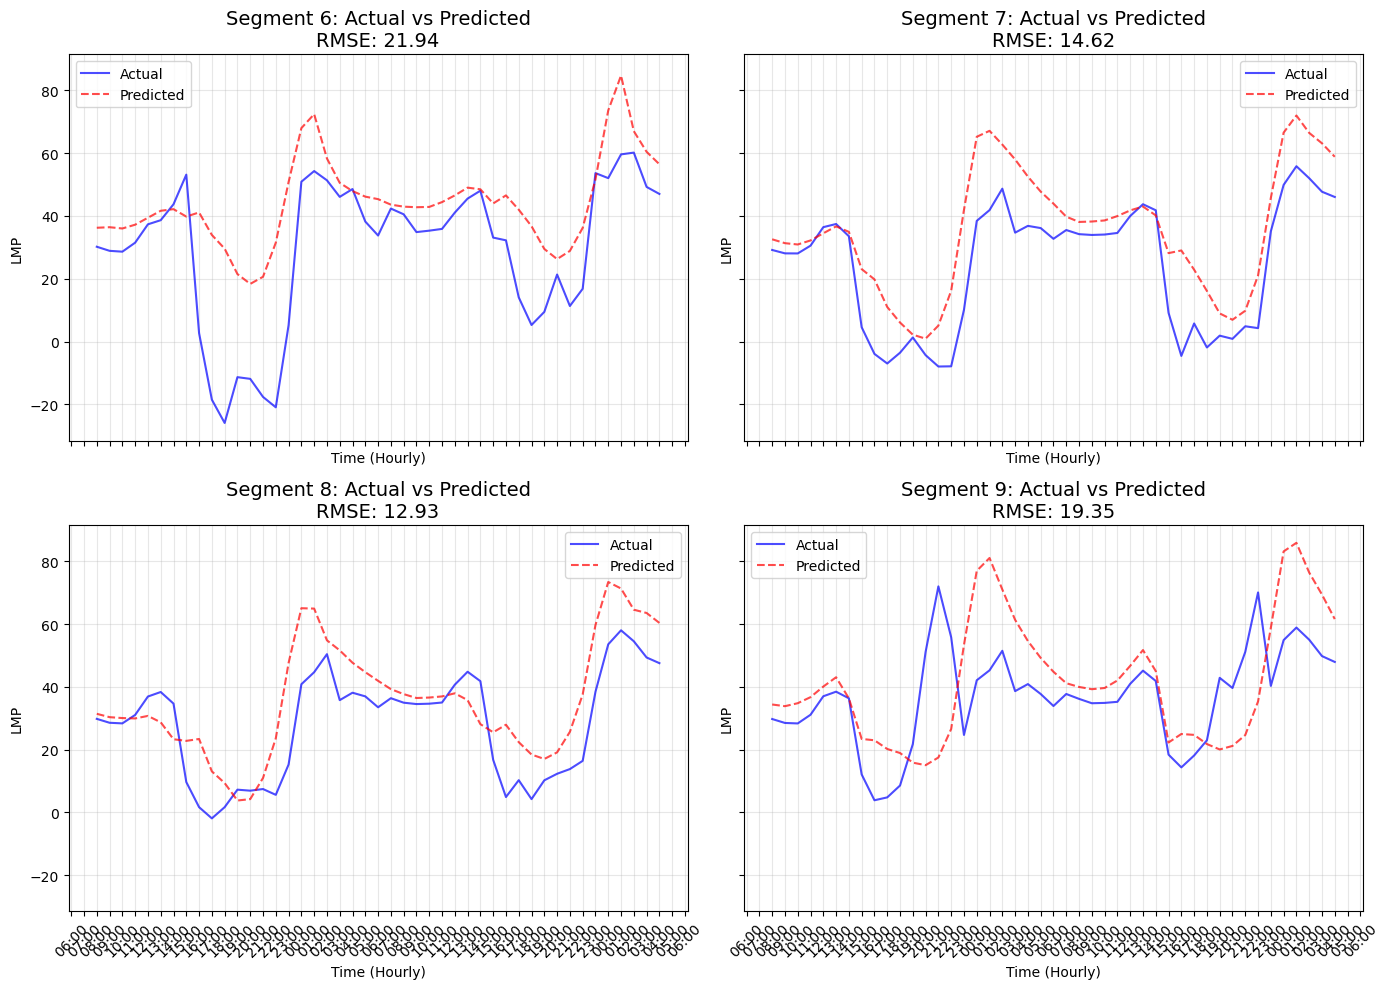

In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator
import matplotlib.pyplot as plt

# Define time range
start_time = "2024-10-20 04:00"
end_time = "2024-10-23 04:00"

# Filter DataFrames
filtered_dfs = {
    6: prediction_df_6[
        (prediction_df_6['Time'] >= start_time) & (prediction_df_6['Time'] <= end_time)
    ],
    7: prediction_df_7[
        (prediction_df_7['Time'] >= start_time) & (prediction_df_7['Time'] <= end_time)
    ],
    8: prediction_df_8[
        (prediction_df_8['Time'] >= start_time) & (prediction_df_8['Time'] <= end_time)
    ],
    9: prediction_df_9[
        (prediction_df_9['Time'] >= start_time) & (prediction_df_9['Time'] <= end_time)
    ]
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Hourly ticks and formatter
locator = HourLocator(interval=1)  # Tick every hour
formatter = DateFormatter('%H:%M')  # Format: HH:MM

# Plot each segment and calculate RMSE
for idx, (segment, filtered_df) in enumerate(filtered_dfs.items()):
    ax = axes[idx]
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(filtered_df['Actual'], filtered_df['Predicted']))
    
    # Plot Actual and Predicted
    ax.plot(filtered_df['Time'], filtered_df['Actual'], label='Actual', color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(filtered_df['Time'], filtered_df['Predicted'], label='Predicted', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Title and labels
    ax.set_title(f'Segment {segment}: Actual vs Predicted\nRMSE: {rmse:.2f}', fontsize=14)
    ax.set_xlabel('Time (Hourly)', fontsize=10)
    ax.set_ylabel('LMP', fontsize=10)
    ax.legend(fontsize=10)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [44]:
# data_list = []

# for segment, df in filtered_dfs.items():
#     if not df.empty:
#         for _, row in df.iterrows():
#             data_list.append({
#                 "Segment": segment,
#                 "Time": row['Time'],
#                 "Actual": row['Actual'],
#                 "Predicted": row['Predicted']
#             })

# # Save the list of dictionaries as a CSV file
# output_file = "filtered_segments.csv"

# with open(output_file, mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.DictWriter(file, fieldnames=["Segment", "Time", "Actual", "Predicted"])
#     writer.writeheader()
#     writer.writerows(data_list)

